# Open Clusters Analytics - 03_Complete Membership analysis of an open cluster

In [5]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import hdbscan
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


In [6]:
def get_cluster_info_from_simbad(cluster_name, default_radius=0.5):
    """
    Obtiene información básica del cúmulo desde SIMBAD.
    
    Parámetros:
    ----------
    cluster_name : str
        Nombre del cúmulo (ej: 'M37', 'NGC 2099', 'Pléyades')
    default_radius : float, default=0.5
        Radio por defecto en grados si SIMBAD no tiene dimensión
    
    Retorna:
    -------
    dict con información del cúmulo
    """
    from astroquery.simbad import Simbad
    
    custom_simbad = Simbad()
    Simbad.reset_votable_fields()
    custom_simbad.add_votable_fields('otype', 'dim', 'plx_value', 'pmra', 'pmdec')
    
    try:
        # Query SIMBAD
        result = custom_simbad.query_object(cluster_name)
        
        if result is None or len(result) == 0:
            raise ValueError(f"Cluster: '{cluster_name}' not found in SIMBAD")
        
        row = result[0]
        
        # Get cluster coordinates (ya vienen en grados)
        ra_center = row['ra']
        dec_center = row['dec']
        
        # Get cluster dimensions
        if row['galdim_majaxis'] is not None and not np.ma.is_masked(row['galdim_majaxis']):
            radius_arcmin = row['galdim_majaxis'] / 2.0
            radius_deg = radius_arcmin / 60.0  # arcmin to deg
        else:
            # Default radius
            radius_deg = default_radius
            print(f"  ⚠ Cluster dimensions not found in SIMBAD, using default radius: {radius_deg}°")
        
        # Extract object type
        obj_type = row['otype'].decode('utf-8') if isinstance(row['otype'], bytes) else str(row['otype'])
        
        # Extract reference values (pueden ser masked)
        plx_simbad = row['plx_value'] if not np.ma.is_masked(row['plx_value']) else None
        pmra_simbad = row['pmra'] if not np.ma.is_masked(row['pmra']) else None
        pmdec_simbad = row['pmdec'] if not np.ma.is_masked(row['pmdec']) else None
        
        # Crear diccionario con información
        cluster_info = {
            'name': cluster_name,
            'ra': ra_center,
            'dec': dec_center,
            'radius': radius_deg,
            'type': obj_type,
            'plx_simbad': plx_simbad,
            'pmra_simbad': pmra_simbad,
            'pmdec_simbad': pmdec_simbad
        }
        
        # Print information
        print(f"\n✓ Information from SIMBAD:")
        print(f"  - Object Type: {obj_type}")
        print(f"  - Coordinates: RA={ra_center:.4f}°, Dec={dec_center:.4f}°")  # Corregido: era ra_deg
        print(f"  - Radius: {radius_deg:.4f}° ({radius_deg*60:.2f} arcmin)")
        
        if plx_simbad is not None:
            distance_pc = 1000.0 / plx_simbad
            print(f"  - Parallax (SIMBAD): {plx_simbad:.3f} mas (≈ {distance_pc:.0f} pc)")
        
        if pmra_simbad is not None and pmdec_simbad is not None:
            print(f"  - PM (SIMBAD): μα*={pmra_simbad:.3f}, μδ={pmdec_simbad:.3f} mas/year")
        
        return cluster_info
        
    except Exception as e:
        print(f"❌ Error getting data from SIMBAD: {e}")
        raise
    

In [7]:
def download_gaia_data(cluster_info, radius_multiplier=2.0, search_radius_deg=None,
                       mag_limit=18.0, max_rows=50000, 
                       gaia_username=None, gaia_password=None,
                       parallax_range_factor=3.0):
    """
    Descarga datos de Gaia DR3 para la región del cúmulo.
    
    PARÁMETROS:
    ----------
    cluster_info : dict
        Información del cúmulo de get_cluster_info_from_simbad()
    radius_multiplier : float, default=2.0
        Factor para ampliar el radio de búsqueda (si no se usa search_radius_deg)
    search_radius_deg : float, optional
        Radio de búsqueda ABSOLUTO en grados (anula radius_multiplier si se especifica)
        Para cúmulos abiertos típicos: 0.5° es estándar
    mag_limit : float, default=18.0
        Límite de magnitud G 
    max_rows : int, default=50000
        Número máximo de filas esperado (para advertencia)
    gaia_username : str, optional
        Usuario de Gaia (para queries muy grandes > 2000 filas)
    gaia_password : str, optional
        Contraseña de Gaia
    parallax_range_factor : float, default=3.0
        Factor para rango de paralaje aceptable.
        Si SIMBAD tiene parallax: plx ± plx/parallax_range_factor
        Ejemplo: plx=0.7, factor=3.0 → rango: 0.467-0.933 mas
        Si es None, no aplica filtro de paralaje
    
    RETORNA:
    -------
    DataFrame con datos de Gaia DR3
    """
    from astroquery.gaia import Gaia
    import numpy as np
    
    print(f"\n📡 Descargando datos de Gaia DR3...")
    
    ra = cluster_info['ra']
    dec = cluster_info['dec']
    
    # =========================================================================
    # Determinar radio de búsqueda
    # =========================================================================
    if search_radius_deg is not None:
        # Prioridad a radio absoluto especificado
        radius_deg = search_radius_deg
        print(f"  - Radio de búsqueda (absoluto): {radius_deg:.4f}° ({radius_deg*60:.2f} arcmin)")
    else:
        # Usar multiplicador sobre radio de SIMBAD
        radius_deg = cluster_info['radius'] * radius_multiplier
        print(f"  - Radio SIMBAD: {cluster_info['radius']:.4f}° ({cluster_info['radius']*60:.2f} arcmin)")
        print(f"  - Factor de multiplicación: {radius_multiplier}×")
        print(f"  - Radio de búsqueda: {radius_deg:.4f}° ({radius_deg*60:.2f} arcmin)")
    
    print(f"  - Centro: RA={ra:.4f}°, Dec={dec:.4f}°")
    print(f"  - Límite de magnitud: G < {mag_limit}")
    
    # =========================================================================
    # Determinar rango de paralaje (FILTRO CRÍTICO)
    # =========================================================================
    apply_parallax_filter = False
    
    if parallax_range_factor is not None and cluster_info.get('plx_simbad') is not None:
        plx_expected = cluster_info['plx_simbad']
        plx_min = plx_expected - plx_expected / parallax_range_factor
        plx_max = plx_expected + plx_expected / parallax_range_factor
        
        # Asegurar valores positivos
        plx_min = max(0.01, plx_min)
        
        apply_parallax_filter = True
        
        print(f"\n  🔍 Filtro de paralaje activado:")
        print(f"    - Paralaje esperado (SIMBAD): {plx_expected:.3f} mas")
        print(f"    - Rango aceptable: {plx_min:.3f} - {plx_max:.3f} mas")
        print(f"    - Distancia equivalente: {1000/plx_max:.0f} - {1000/plx_min:.0f} pc")
        print(f"    - Factor de tolerancia: ±{100/parallax_range_factor:.1f}%")
    else:
        if parallax_range_factor is None:
            print(f"\n  ⚠ Filtro de paralaje DESACTIVADO (parallax_range_factor=None)")
        else:
            print(f"\n  ⚠ SIMBAD no tiene paralaje, NO se aplica filtro de paralaje")
        print(f"    → Se descargarán estrellas a TODAS las distancias")
        print(f"    → Puede haber mucha contaminación de campo")
    
    # =========================================================================
    # Construir query ADQL
    # =========================================================================
    
    # Parte común de la query
    query_base = f"""
    SELECT 
        source_id,
        ra, dec,
        pmra, pmdec,
        parallax,
        phot_g_mean_mag,
        phot_bp_mean_mag,
        phot_rp_mean_mag,
        bp_rp,
        ra_error, dec_error,
        pmra_error, pmdec_error,
        parallax_error,
        ruwe,
        astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {ra}, {dec}, {radius_deg})
    ) = 1
    AND parallax > 0
    AND parallax/parallax_error > 5
    AND pmra IS NOT NULL
    AND pmdec IS NOT NULL
    AND phot_g_mean_mag < {mag_limit}
    AND ruwe < 1.4"""
    
    # Añadir filtro de paralaje si aplica
    if apply_parallax_filter:
        query = query_base + f"""
    AND parallax BETWEEN {plx_min} AND {plx_max}"""
    else:
        query = query_base
    
    # Ordenar por magnitud
    query += """
    ORDER BY phot_g_mean_mag ASC
    """
    
    #print(f"\n📋 Query ADQL:")
    #print(query)
    
    # =========================================================================
    # Autenticación (opcional)
    # =========================================================================
    authenticated = False
    if gaia_username and gaia_password:
        try:
            print(f"\n  Intentando autenticación en Gaia...")
            Gaia.login(user=gaia_username, password=gaia_password)
            authenticated = True
            print("  ✓ Login exitoso en Gaia (queries ilimitadas)")
        except Exception as e:
            print(f"  ⚠ Login falló: {e}")
            print("  → Continuando sin autenticación (límite ~2000 filas)")
    
    # =========================================================================
    # Ejecutar query
    # =========================================================================
    try:
        if authenticated:
            # Query asíncrona (autenticado)
            print(f"\n⏳ Ejecutando query asíncrona (puede tardar 1-2 minutos)...")
            job = Gaia.launch_job_async(query)
            results = job.get_results()
            print(f"  ✓ Descarga completada (async): {len(results)} estrellas")
        else:
            # Query síncrona (anónimo, límite 2000 filas)
            print(f"\n⏳ Ejecutando query síncrona...")
            job = Gaia.launch_job(query)
            results = job.get_results()
            print(f"  ✓ Descarga completada (sync): {len(results)} estrellas")
        
    except Exception as e:
        print(f"\n❌ Error ejecutando query en Gaia: {e}")
        print("\nPosibles causas:")
        print("  - Query demasiado grande (>2000 filas sin autenticación)")
        print("  - Timeout del servidor")
        print("  - Sintaxis ADQL incorrecta")
        raise
    
    # =========================================================================
    # Convertir a Pandas y añadir metadata
    # =========================================================================
    data = results.to_pandas()
    
    # Añadir metadata del cúmulo
    data.attrs['cluster_name'] = cluster_info['name']
    data.attrs['cluster_ra'] = ra
    data.attrs['cluster_dec'] = dec
    data.attrs['cluster_radius'] = cluster_info['radius']
    data.attrs['search_radius'] = radius_deg
    if apply_parallax_filter:
        data.attrs['plx_min'] = plx_min
        data.attrs['plx_max'] = plx_max
    
    # =========================================================================
    # Estadísticas básicas
    # =========================================================================
    print(f"\n📊 Estadísticas de los datos descargados:")
    print(f"  - Total de estrellas: {len(data)}")
    print(f"  - Rango de magnitudes: {data['phot_g_mean_mag'].min():.2f} - {data['phot_g_mean_mag'].max():.2f}")
    print(f"  - Rango de paralajes: {data['parallax'].min():.3f} - {data['parallax'].max():.3f} mas")
    print(f"  - Paralaje mediana: {data['parallax'].median():.3f} mas → dist ≈ {1000/data['parallax'].median():.0f} pc")
    print(f"  - Mediana de RUWE: {data['ruwe'].median():.3f}")
    print(f"  - Error PM medio: {data['pmra_error'].mean():.3f} mas/año")
    
    # =========================================================================
    # Advertencias y validaciones
    # =========================================================================
    
    # Advertencia 1: Muchas estrellas
    if len(results) >= max_rows * 0.95:
        print(f"\n  ⚠ ADVERTENCIA: Se alcanzó el límite de filas (~{max_rows})")
        print(f"    Considera reducir 'search_radius_deg' o 'mag_limit'")
    
    # Advertencia 2: Query grande sin autenticación
    if len(results) >= 2000 and not authenticated:
        print(f"\n  ℹ Query grande sin autenticación")
        print(f"    Para queries >2000 filas, registrate en:")
        print(f"    https://gea.esac.esa.int/archive/")
    
    # Advertencia 3: Pocas estrellas
    if len(results) < 100:
        print(f"\n  ⚠ ADVERTENCIA: Muy pocas estrellas descargadas ({len(results)})")
        print(f"    Posibles causas:")
        print(f"      - Radio de búsqueda muy pequeño")
        print(f"      - Filtro de paralaje muy restrictivo")
        print(f"      - Límite de magnitud muy bajo")
        print(f"    Sugerencias:")
        print(f"      - Aumentar search_radius_deg a 0.5-1.0°")
        print(f"      - Ampliar parallax_range_factor a 2.0")
        print(f"      - Aumentar mag_limit a 18-20")
    
    # Advertencia 4: Rango de paralaje muy grande (sin filtro o filtro inefectivo)
    plx_range = data['parallax'].max() - data['parallax'].min()
    plx_median = data['parallax'].median()
    if plx_range > 3 * plx_median:
        print(f"\n  ⚠ ADVERTENCIA: Rango de paralajes muy grande")
        print(f"    Rango: {data['parallax'].min():.3f} - {data['parallax'].max():.3f} mas")
        print(f"    Ratio: {plx_range/plx_median:.1f}× la mediana")
        print(f"    → Mucha contaminación de estrellas a diferentes distancias")
        print(f"    Sugerencia: Activar filtro de paralaje con parallax_range_factor=3.0")
    
    # Validación: Comparar con SIMBAD
    if cluster_info.get('plx_simbad') is not None:
        plx_diff = abs(data['parallax'].median() - cluster_info['plx_simbad'])
        plx_diff_pct = 100 * plx_diff / cluster_info['plx_simbad']
        
        print(f"\n  📊 Comparación con SIMBAD:")
        print(f"    - Paralaje SIMBAD: {cluster_info['plx_simbad']:.3f} mas")
        print(f"    - Paralaje mediana datos: {data['parallax'].median():.3f} mas")
        print(f"    - Diferencia: {plx_diff:.3f} mas ({plx_diff_pct:.1f}%)")
        
        if plx_diff_pct > 30:
            print(f"    ⚠ Gran diferencia con SIMBAD (>{30}%)")
            print(f"      → Verificar que los datos corresponden al cúmulo correcto")
    
    return data

In [8]:
def prepare_features(data, features=['pmra', 'pmdec', 'parallax'], 
                     use_errors=True, use_position=False):
    """
    Prepara las características para el análisis de clustering.
    
    EXPLICACIÓN:
    -----------
    Esta función es CRÍTICA para el éxito del análisis:
    
    1. SELECCIÓN DE CARACTERÍSTICAS:
       - pmra, pmdec: Movimientos propios (cinemática) - MUY IMPORTANTES
       - parallax: Distancia - Separa cúmulo de estrellas de fondo
       - ra, dec: Posición (opcional) - Útil para cúmulos muy compactos
    
    2. NORMALIZACIÓN ROBUSTA (MAD):
       - Usamos MEDIANA y MAD en lugar de media y desviación estándar
       - MAD = Median Absolute Deviation
       - ¿Por qué? Resistente a outliers (estrellas de campo)
       - Fórmula: X_norm = (X - mediana) / (1.4826 × MAD)
       - Factor 1.4826: Hace que MAD ≈ σ en distribuciones normales
    
    3. PONDERACIÓN POR ERRORES:
       - Gaia proporciona errores observacionales para cada medida
       - Peso = 1 / error²
       - Estrellas con medidas más precisas tienen más influencia
       - Esto es estadísticamente correcto (máxima verosimilitud)
    
    PARÁMETROS:
    ----------
    data : DataFrame
        Datos de Gaia con columnas: pmra, pmdec, parallax, etc.
    features : list, default=['pmra', 'pmdec', 'parallax']
        Características a usar para clustering
    use_errors : bool, default=True
        Si ponderar por errores observacionales
    use_position : bool, default=False
        Si incluir ra, dec como características adicionales
    
    RETORNA:
    -------
    X_processed : ndarray
        Características normalizadas (y ponderadas si use_errors=True)
    medians : ndarray
        Medianas usadas para normalización
    mad : ndarray
        MAD usadas para normalización
    weights : ndarray or None
        Pesos aplicados (None si use_errors=False)
    """
    import numpy as np
    
    print(f"\n" + "="*70)
    print("PREPARACIÓN DE CARACTERÍSTICAS")
    print("="*70)
    print(f"\nCaracterísticas seleccionadas: {features}")
    
    # Copiar datos para no modificar el original
    df = data.copy()
    
    # Agregar posición si se requiere
    if use_position:
        features = list(features) + ['ra', 'dec']
        print(f"  ℹ Añadiendo coordenadas espaciales (ra, dec)")
    
    # Verificar que las características existen
    missing = [f for f in features if f not in df.columns]
    if missing:
        raise ValueError(f"Características faltantes en los datos: {missing}")
    
    # Extraer características
    X = df[features].values
    
    # Verificar que no hay NaN
    if np.any(np.isnan(X)):
        n_nan = np.sum(np.isnan(X))
        print(f"  ⚠ Advertencia: {n_nan} valores NaN encontrados, serán eliminados")
        # Eliminar filas con NaN
        valid_mask = ~np.any(np.isnan(X), axis=1)
        X = X[valid_mask]
        df = df[valid_mask]
        print(f"  → {np.sum(~valid_mask)} filas eliminadas, quedan {len(X)} estrellas")
    
    # ==========================================================================
    # NORMALIZACIÓN ROBUSTA (Mediana y MAD)
    # ==========================================================================
    medians = np.median(X, axis=0)
    mad = np.median(np.abs(X - medians), axis=0)
    
    # Evitar división por cero si MAD = 0 (todas las estrellas iguales)
    mad = np.where(mad < 1e-10, 1.0, mad)
    
    # Normalizar: (x - mediana) / MAD
    # Factor 1.4826 hace que MAD sea comparable a std en distribuciones normales
    X_normalized = (X - medians) / (1.4826 * mad)
    
    print(f"\n  Normalización robusta (Mediana y MAD):")
    print(f"  {'Característica':<15} {'Mediana':>12} {'MAD':>12}")
    print(f"  {'-'*15} {'-'*12} {'-'*12}")
    for i, feat in enumerate(features):
        print(f"  {feat:<15} {medians[i]:12.4f} {mad[i]:12.4f}")
    
    # ==========================================================================
    # PONDERACIÓN POR ERRORES OBSERVACIONALES
    # ==========================================================================
    if use_errors:
        # Nombres de columnas de error (solo para características relevantes)
        error_cols_map = {
            'pmra': 'pmra_error',
            'pmdec': 'pmdec_error', 
            'parallax': 'parallax_error',
            'ra': 'ra_error',
            'dec': 'dec_error'
        }
        
        # Verificar qué errores están disponibles
        available_errors = []
        for feat in features:
            if feat in error_cols_map:
                error_col = error_cols_map[feat]
                if error_col in df.columns:
                    available_errors.append((feat, error_col))
        
        if len(available_errors) > 0:
            print(f"\n  Ponderación por errores observacionales:")
            print(f"  {'Característica':<15} {'Peso Medio':>12} {'Peso Mediano':>12}")
            print(f"  {'-'*15} {'-'*12} {'-'*12}")
            
            # Crear array de pesos (inicializado a 1)
            weights = np.ones_like(X_normalized)
            
            # Aplicar pesos solo a características con errores disponibles
            for i, feat in enumerate(features):
                if feat in error_cols_map and error_cols_map[feat] in df.columns:
                    error_col = error_cols_map[feat]
                    errors = df[error_col].values[~np.any(np.isnan(X), axis=1)] if np.any(np.isnan(data[features].values)) else df[error_col].values
                    
                    # Peso = 1 / error²
                    # Sustituir errores muy pequeños o cero por un mínimo
                    errors = np.where(errors < 1e-6, 1e-6, errors)
                    feature_weights = 1.0 / (errors ** 2)
                    
                    # Normalizar los pesos (mediana = 1 para interpretabilidad)
                    feature_weights = feature_weights / np.median(feature_weights)
                    
                    # Aplicar a esa característica
                    weights[:, i] = feature_weights
                    
                    print(f"  {feat:<15} {feature_weights.mean():12.3f} {np.median(feature_weights):12.3f}")
            
            # Aplicar pesos a las características normalizadas
            # Usamos sqrt(peso) para que peso² quede en la distancia euclidiana
            X_weighted = X_normalized * np.sqrt(weights)
            
            print(f"\n  ✓ Características normalizadas y ponderadas")
            print(f"  → Las estrellas con errores pequeños tienen más peso")
            
            return X_weighted, medians, mad, weights
        else:
            print(f"\n  ⚠ No se encontraron columnas de error")
            print(f"  → Continuando sin ponderación")
            return X_normalized, medians, mad, None
    
    print(f"\n  ✓ Características normalizadas (sin ponderación por errores)")
    return X_normalized, medians, mad, None

In [9]:
def plot_raw_data(data):
    """
    Visualiza los datos crudos en diferentes espacios.
    
    PROPÓSITO:
    ---------
    Antes de aplicar cualquier algoritmo, necesitamos ENTENDER los datos:
    
    1. ¿Hay una concentración visible en movimientos propios?
       → Si SÍ: Hay cúmulo
       → Si NO: Puede estar muy mezclado con el campo
    
    2. ¿Los paralajes muestran un pico?
       → Si SÍ: Cúmulo a distancia bien definida
       → Si NO: Gran dispersión en distancia (problema)
    
    3. ¿El CMD muestra una secuencia?
       → Si SÍ: Cúmulo presente
       → Si NO: Solo campo o cúmulo muy débil
    
    4. ¿Los errores son razonables?
       → Verificar que no hay valores anómalos
    
    PARÁMETROS:
    ----------
    data : DataFrame
        Datos de Gaia descargados
    
    RETORNA:
    -------
    None (muestra gráficos)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # =========================================================================
    # GRÁFICO 1: Distribución espacial (RA vs Dec)
    # =========================================================================
    axes[0, 0].scatter(data['ra'], data['dec'], alpha=0.5, s=10, c='steelblue')
    axes[0, 0].set_xlabel('RA (grados)', fontsize=11)
    axes[0, 0].set_ylabel('Dec (grados)', fontsize=11)
    axes[0, 0].set_title('1. Distribución Espacial en el Cielo', fontsize=12, fontweight='bold')
    axes[0, 0].invert_xaxis()  # Convención astronómica: RA crece hacia la izquierda
    axes[0, 0].grid(alpha=0.3)
    
    # Añadir centro del cúmulo si está en attrs
    if 'cluster_ra' in data.attrs and 'cluster_dec' in data.attrs:
        axes[0, 0].scatter(data.attrs['cluster_ra'], data.attrs['cluster_dec'], 
                          marker='x', s=200, c='red', linewidths=3, 
                          label='Centro (SIMBAD)', zorder=10)
        axes[0, 0].legend()
    
    # =========================================================================
    # GRÁFICO 2: Espacio de movimientos propios (el MÁS IMPORTANTE)
    # =========================================================================
    axes[0, 1].scatter(data['pmra'], data['pmdec'], alpha=0.5, s=10, c='steelblue')
    axes[0, 1].set_xlabel('μα* (mas/año)', fontsize=11)
    axes[0, 1].set_ylabel('μδ (mas/año)', fontsize=11)
    axes[0, 1].set_title('2. Espacio de Movimientos Propios ⭐', fontsize=12, fontweight='bold')
    axes[0, 1].axhline(0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    axes[0, 1].axvline(0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    axes[0, 1].grid(alpha=0.3)
    
    # Añadir valores de SIMBAD si existen
    if 'pmra_simbad' in data.attrs and data.attrs['pmra_simbad'] is not None:
        axes[0, 1].scatter(data.attrs['pmra_simbad'], data.attrs['pmdec_simbad'],
                          marker='x', s=200, c='red', linewidths=3,
                          label='PM SIMBAD', zorder=10)
        axes[0, 1].legend()
    
    # =========================================================================
    # GRÁFICO 3: Distribución de paralajes
    # =========================================================================
    # Filtrar paralajes extremos para mejor visualización
    plx_clean = data['parallax'][(data['parallax'] > 0) & (data['parallax'] < 10)]
    
    axes[0, 2].hist(plx_clean, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
    axes[0, 2].set_xlabel('Paralaje (mas)', fontsize=11)
    axes[0, 2].set_ylabel('Frecuencia', fontsize=11)
    axes[0, 2].set_title('3. Distribución de Paralajes', fontsize=12, fontweight='bold')
    axes[0, 2].axvline(plx_clean.median(), color='red', 
                       linestyle='--', linewidth=2, label=f'Mediana: {plx_clean.median():.3f} mas')
    axes[0, 2].grid(alpha=0.3, axis='y')
    axes[0, 2].legend()
    
    # Añadir distancia estimada
    if plx_clean.median() > 0:
        dist_pc = 1000.0 / plx_clean.median()
        axes[0, 2].text(0.05, 0.95, f'Distancia ≈ {dist_pc:.0f} pc',
                       transform=axes[0, 2].transAxes, fontsize=10,
                       verticalalignment='top', bbox=dict(boxstyle='round', 
                       facecolor='wheat', alpha=0.5))
    
    # =========================================================================
    # GRÁFICO 4: Diagrama Color-Magnitud (CMD)
    # =========================================================================
    axes[1, 0].scatter(data['bp_rp'], data['phot_g_mean_mag'], 
                       alpha=0.4, s=8, c='steelblue')
    axes[1, 0].set_xlabel('BP - RP (mag)', fontsize=11)
    axes[1, 0].set_ylabel('G (mag)', fontsize=11)
    axes[1, 0].set_title('4. Diagrama Color-Magnitud (CMD)', fontsize=12, fontweight='bold')
    axes[1, 0].invert_yaxis()  # Magnitudes más brillantes arriba
    axes[1, 0].grid(alpha=0.3)
    
    # =========================================================================
    # GRÁFICO 5: Paralaje vs Movimiento propio total
    # =========================================================================
    pm_total = np.sqrt(data['pmra']**2 + data['pmdec']**2)
    axes[1, 1].scatter(data['parallax'], pm_total, alpha=0.5, s=10, c='steelblue')
    axes[1, 1].set_xlabel('Paralaje (mas)', fontsize=11)
    axes[1, 1].set_ylabel('Movimiento propio total (mas/año)', fontsize=11)
    axes[1, 1].set_title('5. Paralaje vs PM Total', fontsize=12, fontweight='bold')
    axes[1, 1].grid(alpha=0.3)
    
    # Limitar ejes para mejor visualización
    axes[1, 1].set_xlim(0, np.percentile(data['parallax'], 99))
    axes[1, 1].set_ylim(0, np.percentile(pm_total, 99))
    
    # =========================================================================
    # GRÁFICO 6: Distribución de errores observacionales
    # =========================================================================
    axes[1, 2].hist(data['parallax_error'], bins=50, alpha=0.7, 
                    label='Paralaje', edgecolor='black', color='coral')
    axes[1, 2].hist(data['pmra_error'], bins=50, alpha=0.7, 
                    label='PM RA', edgecolor='black', color='lightblue')
    axes[1, 2].hist(data['pmdec_error'], bins=50, alpha=0.7,
                    label='PM Dec', edgecolor='black', color='lightgreen')
    axes[1, 2].set_xlabel('Error (mas)', fontsize=11)
    axes[1, 2].set_ylabel('Frecuencia', fontsize=11)
    axes[1, 2].set_title('6. Distribución de Errores Observacionales', fontsize=12, fontweight='bold')
    axes[1, 2].legend()
    axes[1, 2].grid(alpha=0.3, axis='y')
    
    # Limitar eje x para mejor visualización
    axes[1, 2].set_xlim(0, np.percentile(data['pmra_error'], 95))
    
    # =========================================================================
    # Ajustes finales
    # =========================================================================
    plt.suptitle(f"Análisis Exploratorio - {data.attrs.get('cluster_name', 'Cúmulo')}", 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # Estadísticas en consola
    # =========================================================================
    print("\n" + "="*70)
    print("ESTADÍSTICAS DE LOS DATOS")
    print("="*70)
    print(f"\nTotal de estrellas: {len(data)}")
    print(f"\n1. MOVIMIENTOS PROPIOS:")
    print(f"   pmra:  {data['pmra'].median():7.3f} ± {data['pmra'].std():6.3f} mas/año")
    print(f"   pmdec: {data['pmdec'].median():7.3f} ± {data['pmdec'].std():6.3f} mas/año")
    print(f"\n2. PARALAJE:")
    print(f"   Mediana: {data['parallax'].median():.3f} mas ({1000/data['parallax'].median():.0f} pc)")
    print(f"   Rango:   {data['parallax'].min():.3f} - {data['parallax'].max():.3f} mas")
    print(f"\n3. FOTOMETRÍA:")
    print(f"   G:      {data['phot_g_mean_mag'].min():.2f} - {data['phot_g_mean_mag'].max():.2f} mag")
    print(f"   BP-RP:  {data['bp_rp'].min():.3f} - {data['bp_rp'].max():.3f} mag")
    print(f"\n4. CALIDAD:")
    print(f"   RUWE mediana: {data['ruwe'].median():.3f}")
    print(f"   Error PM medio: {data['pmra_error'].mean():.3f} mas/año")
    print(f"   Error plx medio: {data['parallax_error'].mean():.3f} mas")
    print("="*70)

In [10]:
def apply_hdbscan(X, min_cluster_size=15, min_samples=5):
    """
    Aplica HDBSCAN para identificación inicial de estructuras.
    
    EXPLICACIÓN DE HDBSCAN:
    ----------------------
    HDBSCAN = Hierarchical Density-Based Spatial Clustering of Applications with Noise
    
    ¿POR QUÉ HDBSCAN PRIMERO?
    -------------------------
    1. NO necesitas saber cuántos clusters hay (a diferencia de K-means o GMM)
    2. Maneja variaciones de densidad (núcleo denso vs halo disperso del cúmulo)
    3. Identifica automáticamente outliers (estrellas de campo)
    4. Proporciona probabilidades de pertenencia
    5. Es JERÁRQUICO: encuentra estructuras a múltiples escalas
    
    CONCEPTO CLAVE - DENSIDAD:
    --------------------------
    HDBSCAN busca regiones donde hay MUCHAS estrellas juntas (alta densidad).
    
    Piensa en un mapa de calor:
    - 🔥🔥🔥 = Cúmulo (muchas estrellas concentradas)
    - 🟦🟦🟦 = Campo (estrellas dispersas)
    
    HDBSCAN dice: "Todo lo que esté en zona 🔥🔥🔥 es un cluster"
    
    PARÁMETROS CLAVE:
    -----------------
    min_cluster_size : int, default=15
        Número mínimo de estrellas para considerar un cluster válido
        
        ¿Qué pasa si lo cambias?
        - Muy pequeño (5-10):  Muchos clusters pequeños, posibles espurios
        - Muy grande (50+):    Solo clusters grandes, puede perder cúmulos pequeños
        - RECOMENDADO: 15-20 para cúmulos abiertos típicos
        
    min_samples : int, default=5
        Puntos mínimos en vecindario para ser "core point"
        
        Controla la ROBUSTEZ ante ruido
        - Muy pequeño (1-2):  Sensible a ruido, clusters "sucios"
        - Muy grande (>10):   Muy restrictivo, puede perder miembros reales
        - REGLA PRÁCTICA: min_samples ≈ min_cluster_size / 3
    
    SALIDAS:
    --------
    clusterer : objeto HDBSCAN
        Contiene toda la información del clustering
    labels : array
        Etiqueta de cluster para cada estrella
        -1 = outlier (campo)
        0, 1, 2... = cluster identificado
    probabilities : array
        Probabilidad de pertenecer al cluster asignado (0 a 1)
    outlier_scores : array
        Qué tan "outlier" es cada punto (0 a 1)
        Valores altos = definitivamente outlier
    
    PARÁMETROS:
    ----------
    X : array (n_estrellas, n_características)
        Características normalizadas de prepare_features()
    min_cluster_size : int, default=15
        Tamaño mínimo de cluster
    min_samples : int, default=5
        Puntos mínimos para core point
    
    RETORNA:
    -------
    clusterer : HDBSCAN object
    labels : array de enteros
    probabilities : array de floats
    outlier_scores : array de floats
    """
    
    print("\n" + "="*70)
    print("FASE 1: ANÁLISIS EXPLORATORIO CON HDBSCAN")
    print("="*70)
    
    print(f"\nParámetros HDBSCAN:")
    print(f"  - min_cluster_size: {min_cluster_size}")
    print(f"  - min_samples: {min_samples}")
    print(f"  - cluster_selection_method: 'eom' (Excess of Mass)")
    
    # ==========================================================================
    # Crear y ajustar HDBSCAN
    # ==========================================================================
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_method='eom',  # Excess of Mass - mejor para astronomía
        prediction_data=True,             # Permite hacer predicciones después
        metric='euclidean'                # Distancia euclidiana (ya ponderada)
    )
    
    print(f"\n⏳ Ejecutando HDBSCAN...")
    labels = clusterer.fit_predict(X)
    probabilities = clusterer.probabilities_
    outlier_scores = clusterer.outlier_scores_
    
    # ==========================================================================
    # Análisis de resultados
    # ==========================================================================
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_outliers = list(labels).count(-1)
    n_total = len(labels)
    
    print(f"\n✓ HDBSCAN completado")
    print(f"\n📊 RESULTADOS:")
    print(f"  - Total de estrellas: {n_total}")
    print(f"  - Clusters detectados: {n_clusters}")
    print(f"  - Outliers identificados: {n_outliers} ({100*n_outliers/n_total:.1f}%)")
    print(f"  - Estrellas en clusters: {n_total - n_outliers} ({100*(n_total-n_outliers)/n_total:.1f}%)")
    
    # ==========================================================================
    # Estadísticas por cluster
    # ==========================================================================
    if n_clusters > 0:
        print(f"\n📋 DETALLES POR CLUSTER:")
        print(f"  {'Cluster':<10} {'N estrellas':<15} {'Prob. media':<15} {'Prob. min':<15}")
        print(f"  {'-'*10} {'-'*15} {'-'*15} {'-'*15}")
        
        for i in range(n_clusters):
            mask = (labels == i)
            n_members = mask.sum()
            mean_prob = probabilities[mask].mean()
            min_prob = probabilities[mask].min()
            
            print(f"  {i:<10} {n_members:<15} {mean_prob:<15.3f} {min_prob:<15.3f}")
    
    # ==========================================================================
    # Distribución de probabilidades
    # ==========================================================================
    if n_clusters > 0:
        print(f"\n📈 DISTRIBUCIÓN DE PROBABILIDADES (no-outliers):")
        non_outliers = labels != -1
        probs_clean = probabilities[non_outliers]
        
        print(f"  - Media:    {probs_clean.mean():.3f}")
        print(f"  - Mediana:  {np.median(probs_clean):.3f}")
        print(f"  - Mínima:   {probs_clean.min():.3f}")
        print(f"  - Máxima:   {probs_clean.max():.3f}")
        
        # Contar por rangos de probabilidad
        high = np.sum(probs_clean > 0.9)
        med = np.sum((probs_clean > 0.5) & (probs_clean <= 0.9))
        low = np.sum(probs_clean <= 0.5)
        
        print(f"\n  Distribución por rangos:")
        print(f"  - Alta confianza (P > 0.9):     {high} ({100*high/len(probs_clean):.1f}%)")
        print(f"  - Media confianza (0.5 < P ≤ 0.9): {med} ({100*med/len(probs_clean):.1f}%)")
        print(f"  - Baja confianza (P ≤ 0.5):     {low} ({100*low/len(probs_clean):.1f}%)")
    
    # ==========================================================================
    # Interpretación y recomendaciones
    # ==========================================================================
    print(f"\n💡 INTERPRETACIÓN:")
    
    if n_clusters == 0:
        print("  ⚠️ NO se detectaron clusters")
        print("  → Posibles causas:")
        print("    • El cúmulo está muy mezclado con el campo")
        print("    • min_cluster_size demasiado grande")
        print("    • Los datos no tienen estructura clara")
        print("  → Recomendaciones:")
        print("    • Revisar plot_raw_data() - ¿hay concentración visible?")
        print("    • Reducir min_cluster_size a 10")
        print("    • Verificar que prepare_features() usó las características correctas")
    
    elif n_clusters == 1:
        print("  ✓ Se detectó 1 cluster (esperado para un cúmulo)")
        prob_mean = probabilities[labels == 0].mean()
        if prob_mean > 0.8:
            print(f"  ✓ Probabilidades altas (media: {prob_mean:.3f}) - cluster bien definido")
        elif prob_mean > 0.6:
            print(f"  ⚠️ Probabilidades moderadas (media: {prob_mean:.3f}) - cluster algo mezclado")
        else:
            print(f"  ⚠️ Probabilidades bajas (media: {prob_mean:.3f}) - cluster muy mezclado con campo")
    
    elif n_clusters >= 2:
        print(f"  ⚠️ Se detectaron {n_clusters} clusters")
        print("  → Posibles explicaciones:")
        print("    • Cúmulo + sub-estructuras (real)")
        print("    • Múltiples cúmulos en la región")
        print("    • min_cluster_size demasiado pequeño (fragmentación)")
        print("  → Siguiente paso:")
        print("    • GMM decidirá cuál es el cúmulo principal")
        print("    • Revisar visualizaciones para entender la estructura")
    
    if n_outliers / n_total > 0.9:
        print(f"\n  ⚠️ Muchos outliers ({100*n_outliers/n_total:.1f}%)")
        print("  → Posible problema con parámetros o datos")
    
    print(f"\n{'='*70}")
    print("Siguiente paso: GMM para refinamiento probabilístico")
    print("="*70)
    
    return clusterer, labels, probabilities, outlier_scores

In [11]:
def plot_hdbscan_results(X, labels, probabilities, data, features=['pmra', 'pmdec', 'parallax']):
    """
    Visualiza los resultados de HDBSCAN en múltiples espacios.
    
    PROPÓSITO:
    ---------
    Después de ejecutar HDBSCAN, necesitamos VER qué encontró:
    1. ¿Los clusters son coherentes en el espacio PM?
    2. ¿Las probabilidades tienen sentido?
    3. ¿Los clusters están concentrados espacialmente?
    4. ¿Forman secuencias en el CMD?
    
    PARÁMETROS:
    ----------
    X : array (n_estrellas, n_características)
        Características normalizadas (de prepare_features)
    labels : array
        Etiquetas de cluster de HDBSCAN
    probabilities : array
        Probabilidades de HDBSCAN
    data : DataFrame
        Datos originales de Gaia
    features : list
        Lista de características usadas (para info)
    
    RETORNA:
    -------
    None (muestra gráficos)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.patches import Ellipse
    
    # Preparar datos
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    
    # Colores para clusters
    colors = plt.cm.Spectral(np.linspace(0, 1, max(len(unique_labels), 2)))
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # ==========================================================================
    # GRÁFICO 1: Clusters en espacio de movimientos propios (EL MÁS IMPORTANTE)
    # ==========================================================================
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Outliers en gris
            col = [0.5, 0.5, 0.5, 0.3]  # Gris transparente
            marker = '.'
            size = 10
            label = f'Outliers ({list(labels).count(-1)})'
            zorder = 1
        else:
            marker = 'o'
            size = 40
            n_members = (labels == k).sum()
            label = f'Cluster {k} ({n_members})'
            zorder = 2
        
        class_member_mask = (labels == k)
        
        axes[0, 0].scatter(
            data['pmra'][class_member_mask], 
            data['pmdec'][class_member_mask],
            c=[col], marker=marker, s=size, alpha=0.7, 
            label=label, edgecolors='black' if k != -1 else 'none',
            linewidth=0.5, zorder=zorder
        )
    
    axes[0, 0].set_xlabel('μα* (mas/año)', fontsize=11)
    axes[0, 0].set_ylabel('μδ (mas/año)', fontsize=11)
    axes[0, 0].set_title('1. Clusters en Espacio de Movimientos Propios', 
                         fontsize=12, fontweight='bold')
    axes[0, 0].axhline(0, color='k', linestyle='--', alpha=0.2, linewidth=0.8)
    axes[0, 0].axvline(0, color='k', linestyle='--', alpha=0.2, linewidth=0.8)
    axes[0, 0].legend(loc='best', fontsize=9)
    axes[0, 0].grid(alpha=0.3)
    
    # Añadir elipse para cluster principal (si existe)
    if n_clusters >= 1:
        main_cluster_mask = (labels == 0)
        if main_cluster_mask.sum() > 5:
            pmra_cluster = data['pmra'][main_cluster_mask]
            pmdec_cluster = data['pmdec'][main_cluster_mask]
            
            # Calcular centro y dispersión
            center_pmra = pmra_cluster.median()
            center_pmdec = pmdec_cluster.median()
            std_pmra = pmra_cluster.std()
            std_pmdec = pmdec_cluster.std()
            
            # Dibujar elipse 2-sigma
            ellipse = Ellipse(
                (center_pmra, center_pmdec), 
                width=4*std_pmra, height=4*std_pmdec,
                facecolor='none', edgecolor='red', 
                linewidth=2, linestyle='--', alpha=0.5,
                label='2σ Cluster 0'
            )
            axes[0, 0].add_patch(ellipse)
    
    # ==========================================================================
    # GRÁFICO 2: Distribución de probabilidades
    # ==========================================================================
    # Histograma solo para no-outliers
    non_outliers_mask = (labels != -1)
    if non_outliers_mask.sum() > 0:
        probs_clean = probabilities[non_outliers_mask]
        
        axes[0, 1].hist(probs_clean, bins=30, alpha=0.7, 
                       edgecolor='black', color='steelblue')
        axes[0, 1].axvline(0.5, color='red', linestyle='--', 
                          linewidth=2, label='P = 0.5')
        axes[0, 1].axvline(0.7, color='orange', linestyle='--', 
                          linewidth=2, label='P = 0.7')
        axes[0, 1].axvline(probs_clean.mean(), color='green', 
                          linestyle='-', linewidth=2, 
                          label=f'Media: {probs_clean.mean():.3f}')
        
        axes[0, 1].set_xlabel('Probabilidad de membresía', fontsize=11)
        axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
        axes[0, 1].set_title('2. Distribución de Probabilidades HDBSCAN', 
                            fontsize=12, fontweight='bold')
        axes[0, 1].legend(fontsize=9)
        axes[0, 1].grid(alpha=0.3, axis='y')
    else:
        axes[0, 1].text(0.5, 0.5, 'No hay clusters detectados', 
                       ha='center', va='center', fontsize=12)
        axes[0, 1].set_title('2. Distribución de Probabilidades', 
                            fontsize=12, fontweight='bold')
    
    # ==========================================================================
    # GRÁFICO 3: Clusters en espacio RA-Dec (distribución espacial)
    # ==========================================================================
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0.5, 0.5, 0.5, 0.3]
            marker = '.'
            size = 10
            zorder = 1
        else:
            marker = 'o'
            size = 40
            zorder = 2
        
        class_member_mask = (labels == k)
        
        axes[0, 2].scatter(
            data['ra'][class_member_mask], 
            data['dec'][class_member_mask],
            c=[col], marker=marker, s=size, alpha=0.7,
            edgecolors='black' if k != -1 else 'none',
            linewidth=0.5, zorder=zorder
        )
    
    axes[0, 2].set_xlabel('RA (grados)', fontsize=11)
    axes[0, 2].set_ylabel('Dec (grados)', fontsize=11)
    axes[0, 2].set_title('3. Distribución Espacial de Clusters', 
                         fontsize=12, fontweight='bold')
    axes[0, 2].invert_xaxis()
    axes[0, 2].grid(alpha=0.3)
    
    # Añadir centro del cúmulo
    if 'cluster_ra' in data.attrs and n_clusters >= 1:
        axes[0, 2].scatter(data.attrs['cluster_ra'], data.attrs['cluster_dec'],
                          marker='x', s=200, c='red', linewidths=3,
                          label='Centro SIMBAD', zorder=10)
        axes[0, 2].legend(fontsize=9)
    
    # ==========================================================================
    # GRÁFICO 4: CMD coloreado por cluster
    # ==========================================================================
    # Primero outliers (fondo)
    outlier_mask = (labels == -1)
    if outlier_mask.sum() > 0:
        axes[1, 0].scatter(
            data['bp_rp'][outlier_mask],
            data['phot_g_mean_mag'][outlier_mask],
            c='lightgray', marker='.', s=10, alpha=0.3, label='Outliers'
        )
    
    # Luego clusters (frente)
    for k, col in zip(unique_labels, colors):
        if k == -1:
            continue  # Ya dibujado
        
        class_member_mask = (labels == k)
        
        axes[1, 0].scatter(
            data['bp_rp'][class_member_mask],
            data['phot_g_mean_mag'][class_member_mask],
            c=[col], marker='o', s=40, alpha=0.8,
            label=f'Cluster {k}', edgecolors='black', linewidth=0.5
        )
    
    axes[1, 0].set_xlabel('BP - RP (mag)', fontsize=11)
    axes[1, 0].set_ylabel('G (mag)', fontsize=11)
    axes[1, 0].set_title('4. CMD Coloreado por Cluster', 
                         fontsize=12, fontweight='bold')
    axes[1, 0].invert_yaxis()
    axes[1, 0].legend(fontsize=9)
    axes[1, 0].grid(alpha=0.3)
    
    # ==========================================================================
    # GRÁFICO 5: Probabilidades vs Outlier Scores
    # ==========================================================================
    if non_outliers_mask.sum() > 0:
        # Scatter plot de probabilidades
        scatter = axes[1, 1].scatter(
            probabilities[non_outliers_mask],
            np.random.uniform(-0.1, 0.1, non_outliers_mask.sum()),  # Jitter vertical
            c=labels[non_outliers_mask], cmap='Spectral',
            s=30, alpha=0.6, edgecolors='black', linewidth=0.3
        )
        
        axes[1, 1].axvline(0.5, color='red', linestyle='--', alpha=0.5, label='P = 0.5')
        axes[1, 1].axvline(0.7, color='orange', linestyle='--', alpha=0.5, label='P = 0.7')
        axes[1, 1].axvline(0.9, color='green', linestyle='--', alpha=0.5, label='P = 0.9')
        
        axes[1, 1].set_xlabel('Probabilidad HDBSCAN', fontsize=11)
        axes[1, 1].set_title('5. Distribución de Probabilidades por Cluster', 
                            fontsize=12, fontweight='bold')
        axes[1, 1].set_yticks([])
        axes[1, 1].set_xlim(-0.05, 1.05)
        axes[1, 1].legend(fontsize=9)
        axes[1, 1].grid(alpha=0.3, axis='x')
        
        # Añadir colorbar
        cbar = plt.colorbar(scatter, ax=axes[1, 1])
        cbar.set_label('Cluster ID', fontsize=9)
    else:
        axes[1, 1].text(0.5, 0.5, 'No hay clusters', 
                       ha='center', va='center', fontsize=12)
        axes[1, 1].set_title('5. Distribución de Probabilidades', 
                            fontsize=12, fontweight='bold')
    
    # ==========================================================================
    # GRÁFICO 6: Resumen estadístico
    # ==========================================================================
    axes[1, 2].axis('off')
    
    # Construir texto de resumen
    summary_lines = []
    summary_lines.append("RESUMEN HDBSCAN")
    summary_lines.append("=" * 40)
    summary_lines.append("")
    summary_lines.append(f"Total estrellas: {len(labels)}")
    summary_lines.append(f"Clusters detectados: {n_clusters}")
    summary_lines.append(f"Outliers: {list(labels).count(-1)} ({100*list(labels).count(-1)/len(labels):.1f}%)")
    summary_lines.append("")
    
    if n_clusters > 0:
        summary_lines.append("POR CLUSTER:")
        summary_lines.append("-" * 40)
        
        for k in range(n_clusters):
            mask = (labels == k)
            n_members = mask.sum()
            prob_mean = probabilities[mask].mean()
            prob_min = probabilities[mask].min()
            prob_max = probabilities[mask].max()
            
            summary_lines.append(f"Cluster {k}:")
            summary_lines.append(f"  N: {n_members}")
            summary_lines.append(f"  P media: {prob_mean:.3f}")
            summary_lines.append(f"  P rango: [{prob_min:.3f}, {prob_max:.3f}]")
            
            # Estadísticas cinemáticas del cluster
            if n_members > 0:
                pmra_med = data['pmra'][mask].median()
                pmdec_med = data['pmdec'][mask].median()
                plx_med = data['parallax'][mask].median()
                
                summary_lines.append(f"  PM: ({pmra_med:.2f}, {pmdec_med:.2f}) mas/año")
                summary_lines.append(f"  Dist: {1000/plx_med:.0f} pc")
            summary_lines.append("")
        
        # Distribución de probabilidades
        if non_outliers_mask.sum() > 0:
            probs_clean = probabilities[non_outliers_mask]
            summary_lines.append("PROBABILIDADES:")
            summary_lines.append("-" * 40)
            summary_lines.append(f"Media: {probs_clean.mean():.3f}")
            summary_lines.append(f"Mediana: {np.median(probs_clean):.3f}")
            summary_lines.append("")
            
            high = np.sum(probs_clean > 0.9)
            med = np.sum((probs_clean > 0.5) & (probs_clean <= 0.9))
            low = np.sum(probs_clean <= 0.5)
            
            summary_lines.append(f"P > 0.9: {high} ({100*high/len(probs_clean):.1f}%)")
            summary_lines.append(f"0.5 < P ≤ 0.9: {med} ({100*med/len(probs_clean):.1f}%)")
            summary_lines.append(f"P ≤ 0.5: {low} ({100*low/len(probs_clean):.1f}%)")
    else:
        summary_lines.append("⚠ NO se detectaron clusters")
        summary_lines.append("")
        summary_lines.append("Posibles causas:")
        summary_lines.append("• Parámetros muy restrictivos")
        summary_lines.append("• Datos muy mezclados")
        summary_lines.append("• Estructura no clara")
    
    summary_lines.append("")
    summary_lines.append("=" * 40)
    summary_lines.append("Siguiente: GMM para refinamiento")
    
    summary_text = "\n".join(summary_lines)
    
    axes[1, 2].text(0.05, 0.95, summary_text, fontsize=9,
                   verticalalignment='top', family='monospace',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # ==========================================================================
    # Título general y ajustes
    # ==========================================================================
    cluster_name = data.attrs.get('cluster_name', 'Cúmulo')
    plt.suptitle(f'Resultados HDBSCAN - {cluster_name}', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.show()
    
    # ==========================================================================
    # Análisis adicional en consola
    # ==========================================================================
    print("\n" + "="*70)
    print("ANÁLISIS VISUAL COMPLETADO")
    print("="*70)
    
    if n_clusters == 0:
        print("\n⚠️ ADVERTENCIA: No se detectaron clusters")
        print("\nRecomendaciones:")
        print("  1. Revisar plot_raw_data() - ¿hay concentración visible?")
        print("  2. Intentar con min_cluster_size más pequeño (ej: 10)")
        print("  3. Verificar prepare_features() - características correctas")
    
    elif n_clusters == 1:
        print("\n✓ RESULTADO ESPERADO: 1 cluster detectado")
        
        mask = (labels == 0)
        prob_mean = probabilities[mask].mean()
        
        if prob_mean > 0.8:
            print("  ✓ Excelente: Probabilidades altas → cluster bien definido")
        elif prob_mean > 0.6:
            print("  ⚠ Moderado: Probabilidades medias → cierta mezcla con campo")
        else:
            print("  ⚠ Bajo: Probabilidades bajas → mucha mezcla con campo")
        
        print(f"\nPróximo paso: GMM refinará estas {mask.sum()} candidatas")
    
    else:
        print(f"\n⚠️ MÚLTIPLES CLUSTERS: {n_clusters} detectados")
        print("\nInterpretaciones posibles:")
        print("  • Sub-estructuras reales en el cúmulo")
        print("  • Múltiples cúmulos en la región")
        print("  • Fragmentación artificial (min_cluster_size muy pequeño)")
        print("\nGMM ayudará a identificar el cluster principal")
    
    print("\n" + "="*70)

In [12]:
# =============================================================================
# SECCIÓN 5: FASE 2 - REFINAMIENTO CON GMM
# =============================================================================

def apply_gmm(X, n_components_from_hdbscan, labels_hdbscan):
    """
    Aplica Gaussian Mixture Model para refinamiento probabilístico.
    
    EXPLICACIÓN DE GMM:
    ------------------
    GMM modela los datos como una mezcla de distribuciones gaussianas.
    Cada componente representa un cluster (o el campo estelar).
    
    ¿POR QUÉ GMM DESPUÉS DE HDBSCAN?
    1. HDBSCAN nos dice CUÁNTOS clusters hay (evita adivinación)
    2. GMM proporciona probabilidades "suaves" y bien calibradas
    3. GMM modela mejor la incertidumbre observacional
    4. Permite asignación probabilística en lugar de "duro" sí/no
    
    NÚMERO DE COMPONENTES:
    ---------------------
    n_components = (clusters_hdbscan) + 1
                   └─ cúmulo(s)      └─ campo estelar
    
    Por ejemplo:
    - HDBSCAN detecta 1 cluster → GMM con 2 componentes
    - HDBSCAN detecta 2 clusters → GMM con 3 componentes
    
    CRITERIOS DE INFORMACIÓN:
    ------------------------
    - BIC (Bayesian Information Criterion): penaliza complejidad
    - AIC (Akaike Information Criterion): similar pero menos restrictivo
    - Menor valor = mejor modelo
    """
    print("\n" + "="*70)
    print("FASE 2: REFINAMIENTO CON GAUSSIAN MIXTURE MODEL")
    print("="*70)
    
    # Determinar número de componentes
    n_clusters_hdbscan = len(set(labels_hdbscan)) - (1 if -1 in labels_hdbscan else 0)
    
    # GMM con componentes = clusters + campo
    n_components = n_clusters_hdbscan + 1
    
    print(f"\nConfiguración GMM:")
    print(f"  - Clusters detectados por HDBSCAN: {n_clusters_hdbscan}")
    print(f"  - Componentes GMM: {n_components} ({n_clusters_hdbscan} cúmulo(s) + 1 campo)")
    
    # Probar diferentes configuraciones
    print(f"\nProbando GMM con diferentes números de componentes...")
    bic_scores = []
    aic_scores = []
    n_comp_range = range(max(2, n_components-1), min(6, n_components+2))
    
    for n in n_comp_range:
        gmm = GaussianMixture(n_components=n, covariance_type='full', 
                             random_state=42, n_init=10)
        gmm.fit(X)
        bic_scores.append(gmm.bic(X))
        aic_scores.append(gmm.aic(X))
        print(f"  n={n}: BIC={gmm.bic(X):.1f}, AIC={gmm.aic(X):.1f}")
    
    # Seleccionar mejor modelo
    best_n = list(n_comp_range)[np.argmin(bic_scores)]
    print(f"\n✓ Mejor número de componentes según BIC: {best_n}")
    
    # Ajustar modelo final
    gmm = GaussianMixture(n_components=best_n, covariance_type='full',
                         random_state=42, n_init=10)
    gmm.fit(X)
    
    # Obtener probabilidades y asignaciones
    probabilities = gmm.predict_proba(X)
    labels_gmm = gmm.predict(X)
    
    # Identificar cuál componente es el cúmulo (componente más compacto)
    # Medimos la compacidad como el determinante de la matriz de covarianza
    compactness = [np.linalg.det(cov) for cov in gmm.covariances_]
    cluster_component = np.argmin(compactness)
    
    print(f"\nResultados GMM:")
    print(f"  ✓ Componente identificado como cúmulo: {cluster_component}")
    print(f"  ✓ Compacidad relativa de componentes:")
    for i, comp in enumerate(compactness):
        is_cluster = " ← CÚMULO" if i == cluster_component else ""
        print(f"     Componente {i}: {comp:.2e}{is_cluster}")
    
    # Probabilidades de membresía al cúmulo
    membership_probs = probabilities[:, cluster_component]
    
    return gmm, labels_gmm, probabilities, membership_probs, cluster_component

In [13]:
def plot_gmm_results(X, labels_gmm, membership_probs, cluster_component, data):
    """
    Visualiza los resultados del GMM.
    """
    print("\nGenerando visualizaciones de GMM...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. Probabilidades de membresía en espacio PM
    scatter = axes[0, 0].scatter(data['pmra'], data['pmdec'], 
                                 c=membership_probs, cmap='RdYlGn',
                                 s=30, alpha=0.7, vmin=0, vmax=1)
    axes[0, 0].set_xlabel('μα* (mas/yr)')
    axes[0, 0].set_ylabel('μδ (mas/yr)')
    axes[0, 0].set_title('Probabilidades de Membresía (GMM)')
    plt.colorbar(scatter, ax=axes[0, 0], label='P(miembro)')
    
    # 2. Distribución de probabilidades
    axes[0, 1].hist(membership_probs, bins=50, alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Probabilidad de membresía')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].set_title('Distribución de Probabilidades GMM')
    axes[0, 1].axvline(0.5, color='r', linestyle='--', label='P=0.5')
    axes[0, 1].axvline(0.7, color='orange', linestyle='--', label='P=0.7')
    axes[0, 1].legend()
    
    # 3. Clasificación binaria con umbral
    threshold = 0.5
    members = membership_probs > threshold
    
    axes[0, 2].scatter(data['ra'][~members], data['dec'][~members],
                      c='gray', marker='x', s=20, alpha=0.3, label='Campo')
    axes[0, 2].scatter(data['ra'][members], data['dec'][members],
                      c='blue', marker='o', s=30, alpha=0.7, label='Cúmulo')
    axes[0, 2].set_xlabel('RA (grados)')
    axes[0, 2].set_ylabel('Dec (grados)')
    axes[0, 2].set_title(f'Miembros con P > {threshold}')
    axes[0, 2].invert_xaxis()
    axes[0, 2].legend()
    
    # 4. CMD coloreado por probabilidad
    scatter = axes[1, 0].scatter(data['bp_rp'], data['phot_g_mean_mag'],
                                c=membership_probs, cmap='RdYlGn',
                                s=30, alpha=0.7, vmin=0, vmax=1)
    axes[1, 0].set_xlabel('BP - RP (mag)')
    axes[1, 0].set_ylabel('G (mag)')
    axes[1, 0].set_title('CMD Coloreado por Probabilidad')
    axes[1, 0].invert_yaxis()
    plt.colorbar(scatter, ax=axes[1, 0], label='P(miembro)')
    
    # 5. Comparación de umbrales
    thresholds = [0.3, 0.5, 0.7, 0.9]
    n_members = [np.sum(membership_probs > t) for t in thresholds]
    
    axes[1, 1].bar(range(len(thresholds)), n_members, alpha=0.7, edgecolor='black')
    axes[1, 1].set_xticks(range(len(thresholds)))
    axes[1, 1].set_xticklabels([f'P>{t}' for t in thresholds])
    axes[1, 1].set_ylabel('Número de miembros')
    axes[1, 1].set_title('Miembros según Umbral de Probabilidad')
    for i, n in enumerate(n_members):
        axes[1, 1].text(i, n, str(n), ha='center', va='bottom')
    
    # 6. Estadísticas
    axes[1, 2].axis('off')
    
    high_prob = np.sum(membership_probs > 0.7)
    medium_prob = np.sum((membership_probs > 0.5) & (membership_probs <= 0.7))
    low_prob = np.sum((membership_probs > 0.3) & (membership_probs <= 0.5))
    
    summary_text = f"""
    RESUMEN GMM
    
    Miembros probables (P > 0.7): {high_prob}
    Miembros posibles (0.5 < P ≤ 0.7): {medium_prob}
    Candidatos débiles (0.3 < P ≤ 0.5): {low_prob}
    
    Probabilidad media: {membership_probs.mean():.3f}
    Probabilidad mediana: {np.median(membership_probs):.3f}
    
    Componente cúmulo: {cluster_component}
    
    Siguiente paso: Validación CMD
    """
    axes[1, 2].text(0.1, 0.5, summary_text, fontsize=12,
                    verticalalignment='center', family='monospace')
    
    plt.tight_layout()
    plt.show()

In [14]:
# =============================================================================
# SECCIÓN 6: FASE 3 - VALIDACIÓN CON CMD
# =============================================================================

def validate_with_cmd(data, membership_probs, threshold=0.5):
    """
    Valida los miembros identificados usando el Diagrama Color-Magnitud.
    
    EXPLICACIÓN DE LA VALIDACIÓN CMD:
    ---------------------------------
    El CMD es una herramienta FUNDAMENTAL en astrofísica estelar.
    
    PRINCIPIO:
    - Las estrellas de un cúmulo tienen la misma edad y metalicidad
    - Por tanto, siguen una secuencia bien definida en el CMD
    - Las estrellas de campo tienen edades/metalicidades variadas → dispersas
    
    VALIDACIÓN:
    1. Identificamos la secuencia principal del cúmulo
    2. Calculamos la dispersión perpendicular a esta secuencia
    3. Estrellas muy alejadas probablemente no son miembros
    
    MÉTRICAS:
    --------
    - Compacidad CMD: Qué tan concentrados están los miembros
    - Contraste: Diferencia entre miembros y no-miembros
    - Pureza: Fracción de miembros en secuencia esperada
    """
    print("\n" + "="*70)
    print("FASE 3: VALIDACIÓN CON DIAGRAMA COLOR-MAGNITUD")
    print("="*70)
    
    # Seleccionar miembros según umbral
    members = membership_probs > threshold
    n_members = np.sum(members)
    
    print(f"\nValidando {n_members} miembros con P > {threshold}")
    
    # Extraer datos CMD
    color = data['bp_rp'].values
    mag = data['phot_g_mean_mag'].values
    
    # CMD de miembros vs no-miembros
    color_members = color[members]
    mag_members = mag[members]
    color_field = color[~members]
    mag_field = mag[~members]
    
    # Calcular dispersión en CMD para miembros
    # Usamos la dispersión perpendicular a la secuencia principal
    
    # Ajuste lineal simple de la secuencia principal
    if len(color_members) > 10:
        # Filtrar outliers para ajuste robusto
        from scipy.stats import linregress
        
        # Ajuste inicial
        slope, intercept, r_value, p_value, std_err = linregress(
            color_members, mag_members
        )
        
        # Calcular residuos
        predicted_mag = slope * color_members + intercept
        residuals = mag_members - predicted_mag
        
        # Filtrar outliers (3-sigma)
        sigma = np.std(residuals)
        inliers = np.abs(residuals) < 3 * sigma
        
        # Re-ajustar sin outliers
        if np.sum(inliers) > 10:
            slope, intercept, r_value, p_value, std_err = linregress(
                color_members[inliers], mag_members[inliers]
            )
        
        # Dispersión perpendicular a la secuencia
        predicted_mag_all = slope * color_members + intercept
        residuals_all = mag_members - predicted_mag_all
        dispersion_members = np.std(residuals_all)
        
        # Dispersión del campo (para comparación)
        predicted_mag_field = slope * color_field + intercept
        residuals_field = mag_field - predicted_mag_field
        dispersion_field = np.std(residuals_field)
        
        # Métricas de calidad
        compactness = dispersion_members
        contrast = dispersion_field / dispersion_members
        
        print(f"\nMétricas de validación CMD:")
        print(f"  ✓ Dispersión de miembros: {dispersion_members:.3f} mag")
        print(f"  ✓ Dispersión de campo: {dispersion_field:.3f} mag")
        print(f"  ✓ Contraste (campo/cúmulo): {contrast:.2f}x")
        print(f"  ✓ Correlación lineal (R²): {r_value**2:.3f}")
        
        # Identificar outliers en CMD
        outliers_cmd = np.abs(residuals_all) > 2 * dispersion_members
        n_outliers_cmd = np.sum(outliers_cmd)
        
        print(f"\n  ⚠ Outliers en CMD: {n_outliers_cmd} ({100*n_outliers_cmd/n_members:.1f}%)")
        print(f"    Estos miembros podrían ser:")
        print(f"    - Binarias no resueltas (más brillantes)")
        print(f"    - Estrellas de campo con cinemática similar")
        print(f"    - Miembros reales con fotometría errónea")
        
        return {
            'slope': slope,
            'intercept': intercept,
            'dispersion_members': dispersion_members,
            'dispersion_field': dispersion_field,
            'contrast': contrast,
            'r_squared': r_value**2,
            'outliers_cmd': outliers_cmd,
            'residuals': residuals_all
        }
    else:
        print("  ⚠ Muy pocos miembros para validación CMD robusta")
        return None

In [15]:
def plot_cmd_validation(data, membership_probs, cmd_results, threshold=0.5):
    """
    Visualiza la validación CMD.
    """
    print("\nGenerando visualización de validación CMD...")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    members = membership_probs > threshold
    
    # 1. CMD con miembros y campo
    axes[0, 0].scatter(data['bp_rp'][~members], 
                      data['phot_g_mean_mag'][~members],
                      c='gray', marker='x', s=10, alpha=0.3, label='Campo')
    axes[0, 0].scatter(data['bp_rp'][members], 
                      data['phot_g_mean_mag'][members],
                      c=membership_probs[members], cmap='RdYlGn',
                      marker='o', s=50, alpha=0.8, vmin=0.5, vmax=1,
                      edgecolors='black', linewidth=0.5)
    
    # Añadir línea de ajuste si existe
    if cmd_results is not None:
        color_range = np.linspace(data['bp_rp'].min(), data['bp_rp'].max(), 100)
        mag_fit = cmd_results['slope'] * color_range + cmd_results['intercept']
        axes[0, 0].plot(color_range, mag_fit, 'r--', linewidth=2, 
                       label='Secuencia ajustada', alpha=0.7)
        
        # Banda de dispersión
        axes[0, 0].fill_between(color_range, 
                               mag_fit - 2*cmd_results['dispersion_members'],
                               mag_fit + 2*cmd_results['dispersion_members'],
                               alpha=0.2, color='red', 
                               label='±2σ miembros')
    
    axes[0, 0].set_xlabel('BP - RP (mag)')
    axes[0, 0].set_ylabel('G (mag)')
    axes[0, 0].set_title('CMD: Miembros Validados')
    axes[0, 0].invert_yaxis()
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # 2. Residuos en CMD
    if cmd_results is not None:
        color_members = data['bp_rp'][members].values
        residuals = cmd_results['residuals']
        outliers = cmd_results['outliers_cmd']
        
        axes[0, 1].scatter(color_members[~outliers], residuals[~outliers],
                          c='blue', s=30, alpha=0.6, label='Inliers')
        axes[0, 1].scatter(color_members[outliers], residuals[outliers],
                          c='red', s=50, alpha=0.8, marker='^', 
                          label='Outliers CMD')
        axes[0, 1].axhline(0, color='k', linestyle='--', alpha=0.5)
        axes[0, 1].axhline(2*cmd_results['dispersion_members'], 
                          color='r', linestyle='--', alpha=0.5, label='±2σ')
        axes[0, 1].axhline(-2*cmd_results['dispersion_members'], 
                          color='r', linestyle='--', alpha=0.5)
        axes[0, 1].set_xlabel('BP - RP (mag)')
        axes[0, 1].set_ylabel('Residuo (mag)')
        axes[0, 1].set_title('Residuos respecto a Secuencia Principal')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)
    
    # 3. Distribución de residuos
    if cmd_results is not None:
        axes[1, 0].hist(residuals, bins=30, alpha=0.7, edgecolor='black',
                       density=True, label='Observado')
        
        # Ajuste gaussiano
        mu, sigma = stats.norm.fit(residuals)
        x = np.linspace(residuals.min(), residuals.max(), 100)
        axes[1, 0].plot(x, stats.norm.pdf(x, mu, sigma), 
                       'r-', linewidth=2, label=f'Gaussiana (σ={sigma:.3f})')
        
        axes[1, 0].set_xlabel('Residuo (mag)')
        axes[1, 0].set_ylabel('Densidad')
        axes[1, 0].set_title('Distribución de Residuos')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)
    
    # 4. Métricas de validación
    axes[1, 1].axis('off')
    
    if cmd_results is not None:
        validation_text = f"""
    VALIDACIÓN CMD - RESULTADOS
    {'='*40}
    
    Ajuste de Secuencia Principal:
    - Pendiente: {cmd_results['slope']:.3f}
    - R²: {cmd_results['r_squared']:.3f}
    
    Dispersión:
    - Miembros: {cmd_results['dispersion_members']:.3f} mag
    - Campo: {cmd_results['dispersion_field']:.3f} mag
    - Contraste: {cmd_results['contrast']:.2f}x
    
    Interpretación del Contraste:
    {cmd_results['contrast']:.1f}x → {"Excelente" if cmd_results['contrast'] > 3 else "Buena" if cmd_results['contrast'] > 2 else "Moderada" if cmd_results['contrast'] > 1.5 else "Débil"} separación
    
    Outliers CMD:
    - Número: {np.sum(cmd_results['outliers_cmd'])}
    - Porcentaje: {100*np.sum(cmd_results['outliers_cmd'])/len(residuals):.1f}%
    
    CONCLUSIÓN:
    {'✓ Validación exitosa' if cmd_results['contrast'] > 2 and cmd_results['r_squared'] > 0.5 else '⚠ Validar manualmente'}
    {'  Secuencia bien definida' if cmd_results['r_squared'] > 0.7 else '  Secuencia moderadamente definida' if cmd_results['r_squared'] > 0.5 else '  Secuencia poco clara'}
        """
    else:
        validation_text = "\nNo hay suficientes datos para validación CMD"
    
    axes[1, 1].text(0.1, 0.5, validation_text, fontsize=10,
                    verticalalignment='center', family='monospace')
    
    plt.tight_layout()
    plt.show()

In [16]:
# =============================================================================
# SECCIÓN 7: MÉTRICAS FINALES Y EVALUACIÓN
# =============================================================================

def calculate_final_metrics(data, membership_probs, hdbscan_labels, 
                           threshold=0.5):
    """
    Calcula métricas finales de rendimiento del análisis.
    
    MÉTRICAS IMPORTANTES:
    --------------------
    Si tenemos ground truth (datos simulados):
    - Precisión: De los que dijimos "miembro", cuántos lo son realmente
    - Recall: De los miembros reales, cuántos identificamos
    - F1-Score: Media armónica de precisión y recall
    
    Sin ground truth (datos reales):
    - Consistencia HDBSCAN-GMM: Concordancia entre métodos
    - Pureza CMD: Concentración en diagrama color-magnitud
    - Silhouette score: Calidad del clustering
    """
    print("\n" + "="*70)
    print("MÉTRICAS FINALES Y EVALUACIÓN")
    print("="*70)
    
    members_gmm = membership_probs > threshold
    
    # Si tenemos ground truth (datos simulados)
    if 'true_member' in data.columns:
        true_members = data['true_member'].values.astype(bool)
        
        # True Positives, False Positives, etc.
        tp = np.sum(members_gmm & true_members)
        fp = np.sum(members_gmm & ~true_members)
        fn = np.sum(~members_gmm & true_members)
        tn = np.sum(~members_gmm & ~true_members)
        
        # Métricas
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + fp + fn + tn)
        
        print(f"\n📊 MÉTRICAS CON GROUND TRUTH:")
        print(f"  ✓ Precisión: {precision:.3f} ({100*precision:.1f}%)")
        print(f"    → De los que identificamos, {100*precision:.1f}% son realmente miembros")
        print(f"  ✓ Recall: {recall:.3f} ({100*recall:.1f}%)")
        print(f"    → Identificamos {100*recall:.1f}% de los miembros reales")
        print(f"  ✓ F1-Score: {f1:.3f}")
        print(f"  ✓ Accuracy: {accuracy:.3f} ({100*accuracy:.1f}%)")
        
        print(f"\n  Matriz de confusión:")
        print(f"    TP (correctamente identificados): {tp}")
        print(f"    FP (falsos positivos): {fp}")
        print(f"    FN (falsos negativos): {fn}")
        print(f"    TN (campo correctamente rechazado): {tn}")
        
        metrics = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'accuracy': accuracy,
            'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
        }
    else:
        print("\n  ℹ No hay ground truth disponible")
        metrics = {}
    
    # Métricas sin ground truth (siempre calculables)
    
    # Consistencia HDBSCAN-GMM
    members_hdbscan = hdbscan_labels >= 0
    agreement = np.sum(members_gmm == members_hdbscan) / len(members_gmm)
    
    print(f"\n📊 MÉTRICAS SIN GROUND TRUTH:")
    print(f"  ✓ Concordancia HDBSCAN-GMM: {agreement:.3f} ({100*agreement:.1f}%)")
    
    # Distribución de probabilidades
    prob_stats = {
        'mean': np.mean(membership_probs),
        'median': np.median(membership_probs),
        'std': np.std(membership_probs),
        'q25': np.percentile(membership_probs, 25),
        'q75': np.percentile(membership_probs, 75)
    }
    
    print(f"\n  Estadísticas de probabilidades:")
    print(f"    Media: {prob_stats['mean']:.3f}")
    print(f"    Mediana: {prob_stats['median']:.3f}")
    print(f"    Desv. estándar: {prob_stats['std']:.3f}")
    print(f"    Cuartiles: [{prob_stats['q25']:.3f}, {prob_stats['q75']:.3f}]")
    
    # Miembros según diferentes umbrales
    print(f"\n  Miembros según umbral:")
    for t in [0.3, 0.5, 0.7, 0.9]:
        n = np.sum(membership_probs > t)
        pct = 100 * n / len(membership_probs)
        print(f"    P > {t}: {n} estrellas ({pct:.1f}%)")
    
    metrics.update({
        'hdbscan_gmm_agreement': agreement,
        'prob_stats': prob_stats
    })
    
    return metrics

In [17]:
def plot_final_comparison(data, membership_probs, hdbscan_labels, 
                          threshold=0.5):
    """
    Visualización final comparando todos los métodos.
    """
    print("\nGenerando visualización comparativa final...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    members_gmm = membership_probs > threshold
    members_hdbscan = hdbscan_labels >= 0
    
    # Si tenemos ground truth
    has_truth = 'true_member' in data.columns
    if has_truth:
        true_members = data['true_member'].values.astype(bool)
    
    # 1. Ground truth (si existe)
    if has_truth:
        axes[0, 0].scatter(data['pmra'][~true_members], 
                          data['pmdec'][~true_members],
                          c='gray', marker='x', s=20, alpha=0.3, label='Campo')
        axes[0, 0].scatter(data['pmra'][true_members], 
                          data['pmdec'][true_members],
                          c='green', marker='o', s=50, alpha=0.7, label='Cúmulo real')
        axes[0, 0].set_title('Ground Truth (Simulación)')
    else:
        axes[0, 0].text(0.5, 0.5, 'No disponible\n(datos reales)', 
                       ha='center', va='center', fontsize=14)
        axes[0, 0].set_title('Ground Truth')
    
    axes[0, 0].set_xlabel('μα* (mas/yr)')
    axes[0, 0].set_ylabel('μδ (mas/yr)')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # 2. Resultados HDBSCAN
    axes[0, 1].scatter(data['pmra'][~members_hdbscan], 
                      data['pmdec'][~members_hdbscan],
                      c='gray', marker='x', s=20, alpha=0.3, label='Outliers')
    axes[0, 1].scatter(data['pmra'][members_hdbscan], 
                      data['pmdec'][members_hdbscan],
                      c='blue', marker='o', s=50, alpha=0.7, label='Clusters')
    axes[0, 1].set_xlabel('μα* (mas/yr)')
    axes[0, 1].set_ylabel('μδ (mas/yr)')
    axes[0, 1].set_title('Resultados HDBSCAN')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # 3. Resultados GMM
    axes[0, 2].scatter(data['pmra'][~members_gmm], 
                      data['pmdec'][~members_gmm],
                      c='gray', marker='x', s=20, alpha=0.3, label='Campo')
    scatter = axes[0, 2].scatter(data['pmra'][members_gmm], 
                                data['pmdec'][members_gmm],
                                c=membership_probs[members_gmm], cmap='RdYlGn',
                                marker='o', s=50, alpha=0.7, vmin=0.5, vmax=1,
                                edgecolors='black', linewidth=0.5)
    axes[0, 2].set_xlabel('μα* (mas/yr)')
    axes[0, 2].set_ylabel('μδ (mas/yr)')
    axes[0, 2].set_title(f'Resultados GMM (P > {threshold})')
    plt.colorbar(scatter, ax=axes[0, 2], label='P(miembro)')
    axes[0, 2].grid(alpha=0.3)
    
    # 4. CMD comparativo
    if has_truth:
        axes[1, 0].scatter(data['bp_rp'][~true_members], 
                          data['phot_g_mean_mag'][~true_members],
                          c='lightgray', marker='.', s=10, alpha=0.3)
        axes[1, 0].scatter(data['bp_rp'][true_members], 
                          data['phot_g_mean_mag'][true_members],
                          c='green', marker='o', s=30, alpha=0.7)
        axes[1, 0].set_title('CMD - Ground Truth')
    else:
        axes[1, 0].scatter(data['bp_rp'], data['phot_g_mean_mag'],
                          c='gray', marker='.', s=10, alpha=0.3)
        axes[1, 0].set_title('CMD - Todos los datos')
    
    axes[1, 0].set_xlabel('BP - RP (mag)')
    axes[1, 0].set_ylabel('G (mag)')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(alpha=0.3)
    
    # 5. CMD - Miembros GMM
    axes[1, 1].scatter(data['bp_rp'][~members_gmm], 
                      data['phot_g_mean_mag'][~members_gmm],
                      c='lightgray', marker='.', s=10, alpha=0.3, label='Campo')
    scatter = axes[1, 1].scatter(data['bp_rp'][members_gmm], 
                                data['phot_g_mean_mag'][members_gmm],
                                c=membership_probs[members_gmm], cmap='RdYlGn',
                                marker='o', s=30, alpha=0.7, vmin=0.5, vmax=1)
    axes[1, 1].set_xlabel('BP - RP (mag)')
    axes[1, 1].set_ylabel('G (mag)')
    axes[1, 1].set_title('CMD - Miembros GMM')
    axes[1, 1].invert_yaxis()
    plt.colorbar(scatter, ax=axes[1, 1], label='P(miembro)')
    axes[1, 1].grid(alpha=0.3)
    
    # 6. Métricas de rendimiento
    axes[1, 2].axis('off')
    
    if has_truth:
        true_members = data['true_member'].values.astype(bool)
        tp = np.sum(members_gmm & true_members)
        fp = np.sum(members_gmm & ~true_members)
        fn = np.sum(~members_gmm & true_members)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics_text = f"""
    RESUMEN FINAL
    {'='*35}
    
    Método: HDBSCAN + GMM + CMD
    Umbral: P > {threshold}
    
    RENDIMIENTO:
    - Precisión: {precision:.3f} ({100*precision:.1f}%)
    - Recall: {recall:.3f} ({100*recall:.1f}%)
    - F1-Score: {f1:.3f}
    
    RESULTADOS:
    - Verdaderos miembros: {np.sum(true_members)}
    - Identificados: {np.sum(members_gmm)}
    - Correctos: {tp}
    - Falsos positivos: {fp}
    - Falsos negativos: {fn}
    
    EVALUACIÓN:
    {get_performance_rating(f1)}
        """
    else:
        n_hdbscan = np.sum(members_hdbscan)
        n_gmm = np.sum(members_gmm)
        agreement = np.sum(members_gmm == members_hdbscan) / len(members_gmm)
        
        metrics_text = f"""
    RESUMEN FINAL
    {'='*35}
    
    Método: HDBSCAN + GMM + CMD
    Umbral: P > {threshold}
    
    RESULTADOS:
    - HDBSCAN: {n_hdbscan} miembros
    - GMM: {n_gmm} miembros
    - Concordancia: {100*agreement:.1f}%
    
    PROBABILIDADES:
    - Media: {np.mean(membership_probs):.3f}
    - Mediana: {np.median(membership_probs):.3f}
    - P > 0.7: {np.sum(membership_probs>0.7)}
    - P > 0.9: {np.sum(membership_probs>0.9)}
    
    Workflow completado ✓
        """
    
    axes[1, 2].text(0.1, 0.5, metrics_text, fontsize=11,
                    verticalalignment='center', family='monospace')
    
    plt.tight_layout()
    plt.show()

In [18]:
def get_performance_rating(f1_score):
    """Evalúa el rendimiento basado en F1-score."""
    if f1_score >= 0.9:
        return "★★★★★ Excelente"
    elif f1_score >= 0.8:
        return "★★★★☆ Muy bueno"
    elif f1_score >= 0.7:
        return "★★★☆☆ Bueno"
    elif f1_score >= 0.6:
        return "★★☆☆☆ Aceptable"
    else:
        return "★☆☆☆☆ Necesita revisión"


In [19]:
# =============================================================================
# SECCIÓN 8: WORKFLOW COMPLETO - EJECUCIÓN PRINCIPAL
# =============================================================================

def run_complete_workflow(data, features=['pmra', 'pmdec', 'parallax'],
                         hdbscan_params={'min_cluster_size': 15, 'min_samples': 5},
                         gmm_threshold=0.5,
                         use_errors=True):
    """
    Ejecuta el workflow completo de análisis de membresía.
    
    RESUMEN DEL WORKFLOW:
    --------------------
    1. Preparación de datos (normalización, ponderación por errores)
    2. HDBSCAN exploratorio (identificar estructuras)
    3. GMM refinamiento (probabilidades calibradas)
    4. Validación CMD (verificar consistencia física)
    5. Métricas finales (evaluar rendimiento)
    
    PARÁMETROS:
    ----------
    data : DataFrame con datos de Gaia
    features : Lista de características a usar ['pmra', 'pmdec', 'parallax']
    hdbscan_params : Parámetros para HDBSCAN
    gmm_threshold : Umbral de probabilidad para considerar miembro
    use_errors : Si incorporar errores observacionales
    
    RETORNA:
    -------
    results : Diccionario con todos los resultados
    """
    print("\n" + "="*70)
    print("INICIANDO WORKFLOW COMPLETO DE ANÁLISIS DE MEMBRESÍA")
    print("="*70)
    print(f"\nDataset: {len(data)} estrellas")
    print(f"Características: {features}")
    print(f"Errores observacionales: {'Sí' if use_errors else 'No'}")
    
    results = {}
    
    # =========================================================================
    # PASO 1: Preparación de datos
    # =========================================================================
    X, medians, mad, weights = prepare_features(data, features, use_errors)
    results['X'] = X
    results['normalization'] = {'medians': medians, 'mad': mad, 'weights': weights}
    
    # =========================================================================
    # PASO 2: HDBSCAN
    # =========================================================================
    clusterer, labels_hdbscan, probs_hdbscan, outlier_scores = apply_hdbscan(
        X, **hdbscan_params
    )
    results['hdbscan'] = {
        'clusterer': clusterer,
        'labels': labels_hdbscan,
        'probabilities': probs_hdbscan,
        'outlier_scores': outlier_scores
    }
    
    plot_hdbscan_results(X, labels_hdbscan, probs_hdbscan, data)
    
    # =========================================================================
    # PASO 3: GMM
    # =========================================================================
    gmm, labels_gmm, probs_gmm, membership_probs, cluster_comp = apply_gmm(
        X, len(set(labels_hdbscan)) - (1 if -1 in labels_hdbscan else 0), 
        labels_hdbscan
    )
    results['gmm'] = {
        'model': gmm,
        'labels': labels_gmm,
        'probabilities': probs_gmm,
        'membership_probs': membership_probs,
        'cluster_component': cluster_comp
    }
    
    plot_gmm_results(X, labels_gmm, membership_probs, cluster_comp, data)
    
    # =========================================================================
    # PASO 4: Validación CMD
    # =========================================================================
    cmd_results = validate_with_cmd(data, membership_probs, gmm_threshold)
    results['cmd_validation'] = cmd_results
    
    if cmd_results is not None:
        plot_cmd_validation(data, membership_probs, cmd_results, gmm_threshold)
    
    # =========================================================================
    # PASO 5: Métricas finales
    # =========================================================================
    final_metrics = calculate_final_metrics(
        data, membership_probs, labels_hdbscan, gmm_threshold
    )
    results['metrics'] = final_metrics
    
    plot_final_comparison(data, membership_probs, labels_hdbscan, gmm_threshold)
    
    # =========================================================================
    # RESUMEN EJECUTIVO
    # =========================================================================
    print("\n" + "="*70)
    print("WORKFLOW COMPLETADO")
    print("="*70)
    
    n_members = np.sum(membership_probs > gmm_threshold)
    print(f"\n✓ Miembros identificados (P > {gmm_threshold}): {n_members}")
    print(f"✓ Probabilidad media: {membership_probs.mean():.3f}")
    
    if 'precision' in final_metrics:
        print(f"✓ Precisión: {final_metrics['precision']:.3f}")
        print(f"✓ Recall: {final_metrics['recall']:.3f}")
        print(f"✓ F1-Score: {final_metrics['f1_score']:.3f}")
    
    print(f"\nResultados guardados en diccionario 'results'")
    print("Accede a:")
    print("  - results['gmm']['membership_probs'] → Probabilidades de membresía")
    print("  - results['hdbscan']['labels'] → Clusters HDBSCAN")
    print("  - results['metrics'] → Métricas de evaluación")
    
    return results


# =============================================================================
# EJECUCIÓN DEL NOTEBOOK
# =============================================================================

if __name__ == "__main__":
    print("="*70)
    print("WORKFLOW DE ANÁLISIS DE MEMBRESÍA EN CÚMULOS ESTELARES ABIERTOS")
    print("="*70)
    print("\nEste notebook implementa un workflow integrado que combina:")
    print("  1. HDBSCAN para exploración inicial")
    print("  2. GMM para refinamiento probabilístico")
    print("  3. Validación CMD para verificación física")
    print("\n" + "="*70)
    
    # Cargar datos
    print("\n📂 Cargando datos...")
    data = load_gaia_data(simulate=True)
    
    # Visualización inicial
    print("\n📊 Visualizando datos crudos...")
    plot_raw_data(data)
    
    # Ejecutar workflow completo
    print("\n🚀 Ejecutando workflow completo...")
    results = run_complete_workflow(
        data,
        features=['pmra', 'pmdec', 'parallax'],
        hdbscan_params={'min_cluster_size': 15, 'min_samples': 5},
        gmm_threshold=0.5,
        use_errors=True
    )
    
    # Los resultados están disponibles en la variable 'results'
    print("\n✅ ¡Análisis completado!")
    print("\nPara usar con tus propios datos:")
    print("  1. Carga tu archivo: data = pd.read_csv('tu_archivo.csv')")
    print("  2. Ejecuta: results = run_complete_workflow(data)")
    print("  3. Extrae miembros: members = results['gmm']['membership_probs'] > 0.5")

WORKFLOW DE ANÁLISIS DE MEMBRESÍA EN CÚMULOS ESTELARES ABIERTOS

Este notebook implementa un workflow integrado que combina:
  1. HDBSCAN para exploración inicial
  2. GMM para refinamiento probabilístico
  3. Validación CMD para verificación física


📂 Cargando datos...


NameError: name 'load_gaia_data' is not defined

In [ ]:
# ============================================================================
# PASO 1: DESCARGAR Y ANALIZAR (sin filtro estricto todavía)
# ============================================================================
cluster_info = get_cluster_info_from_simbad('M37')

data = download_gaia_data(
    cluster_info,
    search_radius_deg=0.5,        # ✅ Radio absoluto: 0.5° (30 arcmin)
    mag_limit=20.0,               # ✅ Magnitud límite amplia
    parallax_range_factor=3.0,    # ✅ Filtro de paralaje: ±33%
    gaia_username='user',         # Opcional (para >2000 filas)
    gaia_password='pass'
)
print(f"\n📊 DATOS DESCARGADOS: {len(data)} estrellas")


✓ Information from SIMBAD:
  - Object Type: OpC
  - Coordinates: RA=88.0773°, Dec=32.5434°
  - Radius: 0.1608° (9.65 arcmin)
  - Parallax (SIMBAD): 0.666 mas (≈ 1502 pc)
  - PM (SIMBAD): μα*=1.924, μδ=-5.648 mas/year

📡 Descargando datos de Gaia DR3...
  - Radio de búsqueda (absoluto): 0.5000° (30.00 arcmin)
  - Centro: RA=88.0773°, Dec=32.5434°
  - Límite de magnitud: G < 20.0

  🔍 Filtro de paralaje activado:
    - Paralaje esperado (SIMBAD): 0.666 mas
    - Rango aceptable: 0.444 - 0.888 mas
    - Distancia equivalente: 1126 - 2252 pc
    - Factor de tolerancia: ±33.3%

  Intentando autenticación en Gaia...
INFO: Login to gaia TAP server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
  ✓ Login exitoso en Gaia (queries ilimitadas)

⏳ Ejecutando query asíncrona (puede tardar 1-2 minutos)...
INFO: Query finished. [astroquery.utils.tap.core]
  ✓ Descarga completada (async): 3967 est


ANÁLISIS DE DATOS DESCARGADOS

📊 RESUMEN:
  - Total de estrellas: 3967

📏 ANÁLISIS DE PARALAJES:
  - SIMBAD: 0.666 mas
  - Mínimo: 0.444 mas → 2252 pc
  - P25:    0.577 mas
  - Mediana:0.658 mas → 1519 pc
  - P75:    0.713 mas
  - Máximo: 0.888 mas → 1126 pc
  - Rango total: 0.444 mas

🎯 ANÁLISIS DE MOVIMIENTOS PROPIOS:
  - SIMBAD PM RA:  1.924
  - SIMBAD PM Dec: -5.648

  - Datos PM RA:
      Mediana: 1.746 mas/año
      Std:     1.985 mas/año
  - Datos PM Dec:
      Mediana: -5.427 mas/año
      Std:     2.623 mas/año

✨ ANÁLISIS DE MAGNITUDES:
  - Rango: 8.07 - 18.38
  - Mediana: 16.15
  - G 8-12: 126 estrellas (3.2%)
  - G 12-14: 484 estrellas (12.2%)
  - G 14-16: 1244 estrellas (31.4%)
  - G 16-18: 2054 estrellas (51.8%)
  - G 18-20: 59 estrellas (1.5%)


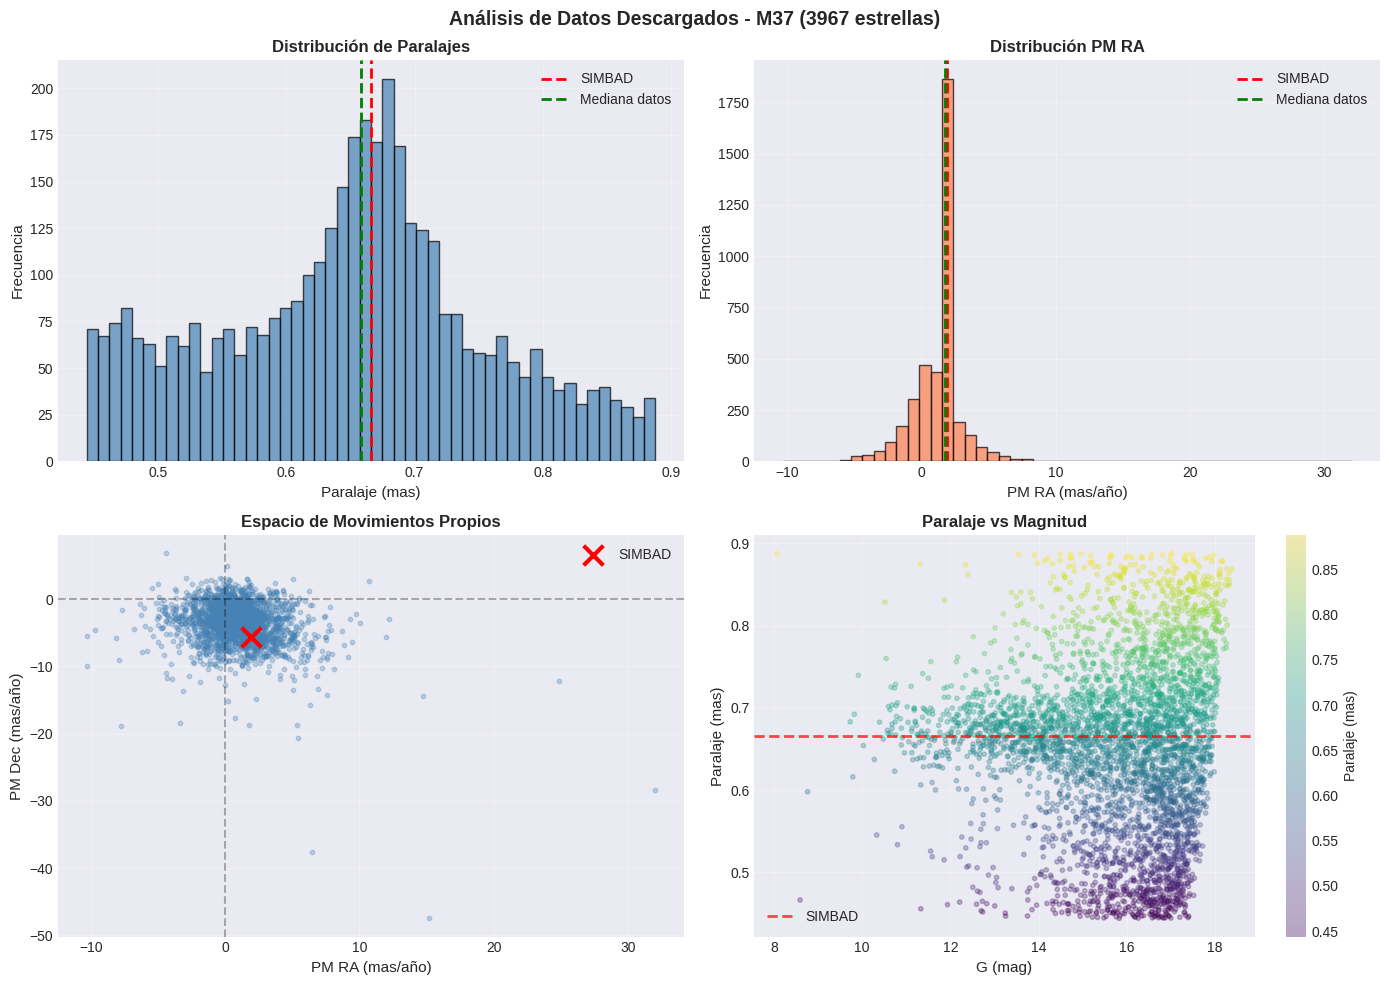


DIAGNÓSTICO

1. ESTRUCTURA EN PARALAJES:
   Estrellas cerca de la mediana (±2 MAD): 2934 (74.0%)
   ✓ HAY estructura clara en paralaje (pico visible)

2. COHERENCIA CON SIMBAD:
   Diferencia: 0.008 mas (1.1%)
   ✓ Excelente concordancia con SIMBAD

3. CANTIDAD DE DATOS:
   ⚠ MUCHAS estrellas (3967)
   → Posible exceso de contaminación
   → Considerar filtros adicionales



In [21]:
# ============================================================================
# ANÁLISIS DETALLADO DE LOS DATOS DESCARGADOS
# ============================================================================

print("\n" + "="*70)
print("ANÁLISIS DE DATOS DESCARGADOS")
print("="*70)

print(f"\n📊 RESUMEN:")
print(f"  - Total de estrellas: {len(data)}")

# Análisis de paralajes (CRÍTICO)
print(f"\n📏 ANÁLISIS DE PARALAJES:")
print(f"  - SIMBAD: {cluster_info.get('plx_simbad', 'N/A'):.3f} mas")
print(f"  - Mínimo: {data['parallax'].min():.3f} mas → {1000/data['parallax'].min():.0f} pc")
print(f"  - P25:    {data['parallax'].quantile(0.25):.3f} mas")
print(f"  - Mediana:{data['parallax'].median():.3f} mas → {1000/data['parallax'].median():.0f} pc")
print(f"  - P75:    {data['parallax'].quantile(0.75):.3f} mas")
print(f"  - Máximo: {data['parallax'].max():.3f} mas → {1000/data['parallax'].max():.0f} pc")

plx_range = data['parallax'].max() - data['parallax'].min()
print(f"  - Rango total: {plx_range:.3f} mas")

# Análisis de movimientos propios
print(f"\n🎯 ANÁLISIS DE MOVIMIENTOS PROPIOS:")
print(f"  - SIMBAD PM RA:  {cluster_info.get('pmra_simbad', 'N/A')}")
print(f"  - SIMBAD PM Dec: {cluster_info.get('pmdec_simbad', 'N/A')}")
print(f"\n  - Datos PM RA:")
print(f"      Mediana: {data['pmra'].median():.3f} mas/año")
print(f"      Std:     {data['pmra'].std():.3f} mas/año")
print(f"  - Datos PM Dec:")
print(f"      Mediana: {data['pmdec'].median():.3f} mas/año")
print(f"      Std:     {data['pmdec'].std():.3f} mas/año")

# Análisis de magnitudes
print(f"\n✨ ANÁLISIS DE MAGNITUDES:")
print(f"  - Rango: {data['phot_g_mean_mag'].min():.2f} - {data['phot_g_mean_mag'].max():.2f}")
print(f"  - Mediana: {data['phot_g_mean_mag'].median():.2f}")

# Distribución por rangos de magnitud
for mag_bin in [(8, 12), (12, 14), (14, 16), (16, 18), (18, 20)]:
    n = len(data[(data['phot_g_mean_mag'] >= mag_bin[0]) & 
                 (data['phot_g_mean_mag'] < mag_bin[1])])
    print(f"  - G {mag_bin[0]}-{mag_bin[1]}: {n} estrellas ({100*n/len(data):.1f}%)")

# ============================================================================
# GRÁFICOS DIAGNÓSTICOS (MUY IMPORTANTES)
# ============================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histograma de paralajes
axes[0, 0].hist(data['parallax'], bins=50, alpha=0.7, edgecolor='black', color='steelblue')
if cluster_info.get('plx_simbad'):
    axes[0, 0].axvline(cluster_info['plx_simbad'], color='red', 
                       linestyle='--', linewidth=2, label='SIMBAD')
axes[0, 0].axvline(data['parallax'].median(), color='green',
                  linestyle='--', linewidth=2, label='Mediana datos')
axes[0, 0].set_xlabel('Paralaje (mas)', fontsize=11)
axes[0, 0].set_ylabel('Frecuencia', fontsize=11)
axes[0, 0].set_title('Distribución de Paralajes', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Histograma de movimientos propios RA
axes[0, 1].hist(data['pmra'], bins=50, alpha=0.7, edgecolor='black', color='coral')
if cluster_info.get('pmra_simbad'):
    axes[0, 1].axvline(cluster_info['pmra_simbad'], color='red',
                      linestyle='--', linewidth=2, label='SIMBAD')
axes[0, 1].axvline(data['pmra'].median(), color='green',
                  linestyle='--', linewidth=2, label='Mediana datos')
axes[0, 1].set_xlabel('PM RA (mas/año)', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].set_title('Distribución PM RA', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Scatter PM RA vs PM Dec
axes[1, 0].scatter(data['pmra'], data['pmdec'], alpha=0.3, s=10, c='steelblue')
axes[1, 0].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[1, 0].axvline(0, color='k', linestyle='--', alpha=0.3)
if cluster_info.get('pmra_simbad') and cluster_info.get('pmdec_simbad'):
    axes[1, 0].scatter(cluster_info['pmra_simbad'], cluster_info['pmdec_simbad'],
                      marker='x', s=200, c='red', linewidths=3, label='SIMBAD', zorder=10)
    axes[1, 0].legend()
axes[1, 0].set_xlabel('PM RA (mas/año)', fontsize=11)
axes[1, 0].set_ylabel('PM Dec (mas/año)', fontsize=11)
axes[1, 0].set_title('Espacio de Movimientos Propios', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 4. Paralaje vs Magnitud
scatter = axes[1, 1].scatter(data['phot_g_mean_mag'], data['parallax'], 
                             alpha=0.3, s=10, c=data['parallax'], cmap='viridis')
if cluster_info.get('plx_simbad'):
    axes[1, 1].axhline(cluster_info['plx_simbad'], color='red',
                      linestyle='--', linewidth=2, label='SIMBAD', alpha=0.7)
    axes[1, 1].legend()
axes[1, 1].set_xlabel('G (mag)', fontsize=11)
axes[1, 1].set_ylabel('Paralaje (mas)', fontsize=11)
axes[1, 1].set_title('Paralaje vs Magnitud', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label='Paralaje (mas)')

plt.suptitle(f'Análisis de Datos Descargados - {cluster_info["name"]} ({len(data)} estrellas)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# DIAGNÓSTICO Y RECOMENDACIONES
# ============================================================================

print("\n" + "="*70)
print("DIAGNÓSTICO")
print("="*70)

# ¿Hay pico claro en paralajes?
plx_median = data['parallax'].median()
plx_mad = np.median(np.abs(data['parallax'] - plx_median))
n_near_median = len(data[np.abs(data['parallax'] - plx_median) < 2*plx_mad])
pct_near_median = 100 * n_near_median / len(data)

print(f"\n1. ESTRUCTURA EN PARALAJES:")
print(f"   Estrellas cerca de la mediana (±2 MAD): {n_near_median} ({pct_near_median:.1f}%)")

if pct_near_median > 50:
    print(f"   ✓ HAY estructura clara en paralaje (pico visible)")
elif pct_near_median > 30:
    print(f"   ⚠ Estructura moderada en paralaje")
else:
    print(f"   ❌ Poca estructura, mucha dispersión")

# ¿Coincide con SIMBAD?
if cluster_info.get('plx_simbad'):
    plx_diff = abs(data['parallax'].median() - cluster_info['plx_simbad'])
    plx_diff_pct = 100 * plx_diff / cluster_info['plx_simbad']
    
    print(f"\n2. COHERENCIA CON SIMBAD:")
    print(f"   Diferencia: {plx_diff:.3f} mas ({plx_diff_pct:.1f}%)")
    
    if plx_diff_pct < 10:
        print(f"   ✓ Excelente concordancia con SIMBAD")
    elif plx_diff_pct < 20:
        print(f"   ✓ Buena concordancia con SIMBAD")
    else:
        print(f"   ⚠ Diferencia significativa con SIMBAD")

print(f"\n3. CANTIDAD DE DATOS:")
if len(data) > 3000:
    print(f"   ⚠ MUCHAS estrellas ({len(data)})")
    print(f"   → Posible exceso de contaminación")
    print(f"   → Considerar filtros adicionales")
elif len(data) > 1500:
    print(f"   ✓ Cantidad razonable ({len(data)})")
elif len(data) < 800:
    print(f"   ⚠ Pocas estrellas ({len(data)})")
    print(f"   → Puede perder miembros reales")

print("\n" + "="*70)

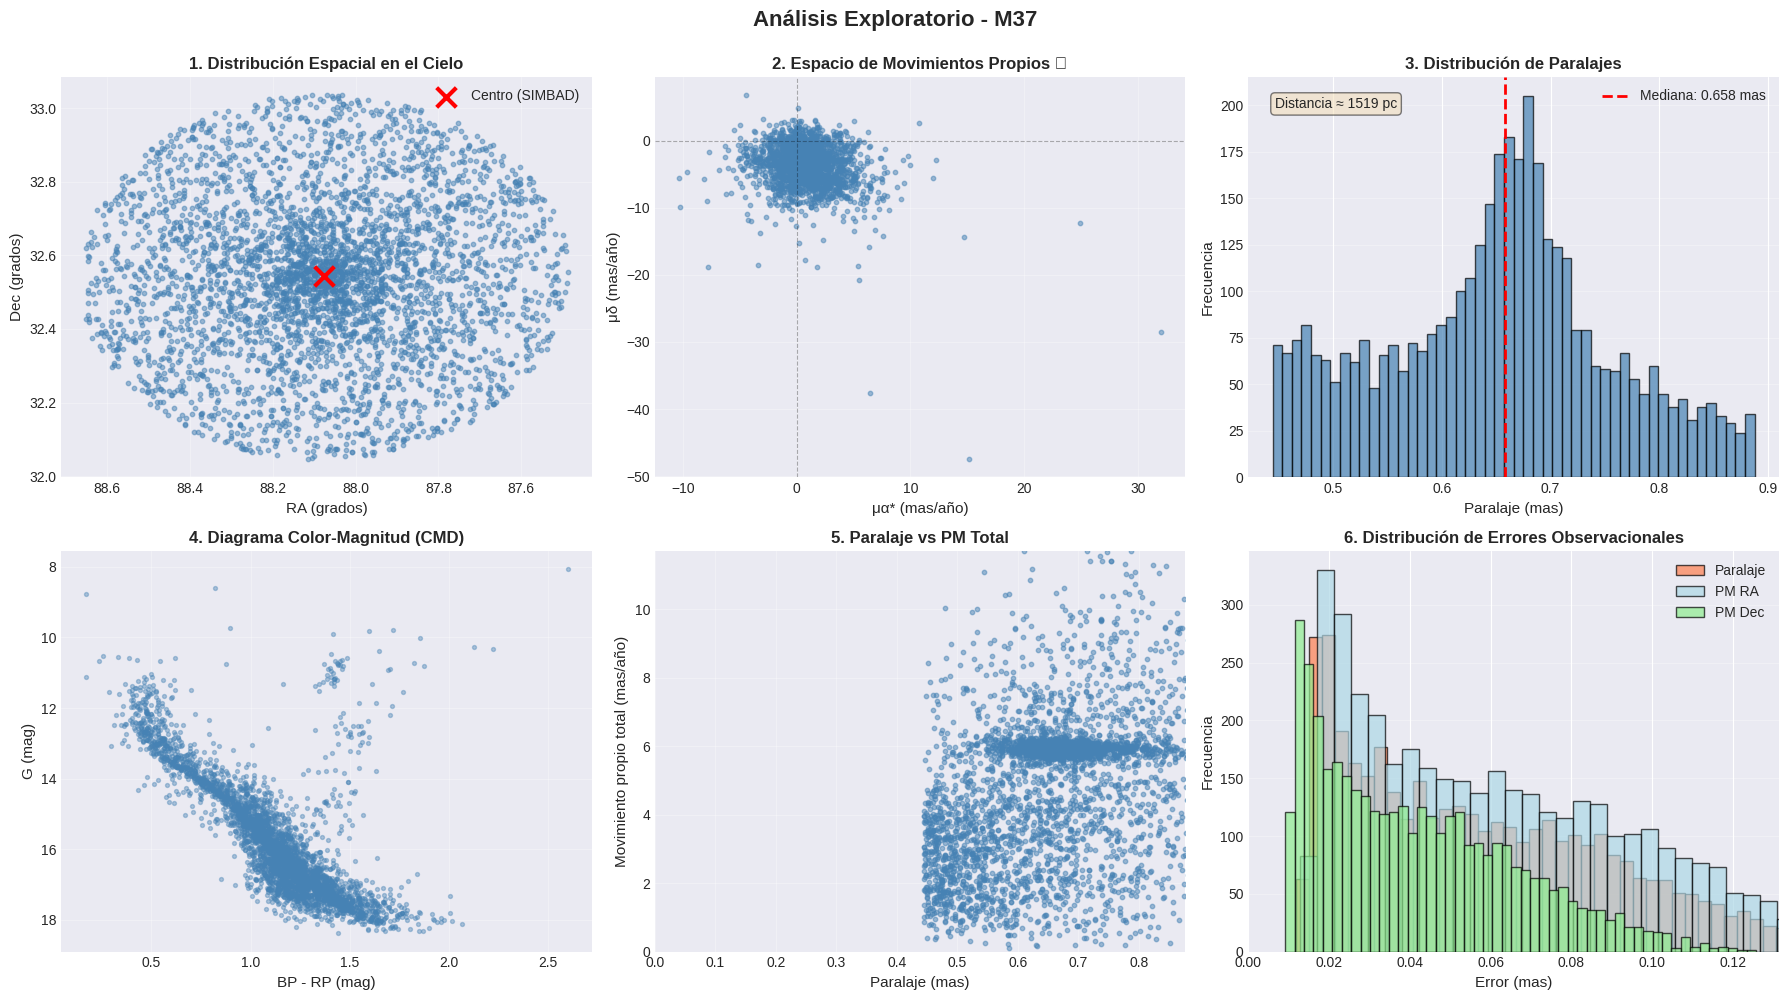


ESTADÍSTICAS DE LOS DATOS

Total de estrellas: 3967

1. MOVIMIENTOS PROPIOS:
   pmra:    1.746 ±  1.985 mas/año
   pmdec:  -5.427 ±  2.623 mas/año

2. PARALAJE:
   Mediana: 0.658 mas (1519 pc)
   Rango:   0.444 - 0.888 mas

3. FOTOMETRÍA:
   G:      8.07 - 18.38 mag
   BP-RP:  0.168 - 2.599 mag

4. CALIDAD:
   RUWE mediana: 1.010
   Error PM medio: 0.063 mas/año
   Error plx medio: 0.058 mas


In [22]:
# ============================================================================
# PASO 2: VISUALIZAR PRIMERO (crítico para entender)
# ============================================================================
plot_raw_data(data)

In [23]:
# ============================================================================
# PASO 3: ANALIZAR PARALAJES
# ============================================================================
print("\n📊 ANÁLISIS DE PARALAJES:")
print(f"  SIMBAD:  {cluster_info.get('plx_simbad', 'N/A'):.3f} mas")
print(f"  Mediana: {data['parallax'].median():.3f} mas")
print(f"  MAD:     {np.median(np.abs(data['parallax'] - data['parallax'].median())):.3f} mas")



📊 ANÁLISIS DE PARALAJES:
  SIMBAD:  0.666 mas
  Mediana: 0.658 mas
  MAD:     0.066 mas


In [25]:
# ============================================================================
# PASO 4: FILTRAR BASÁNDOSE EN LOS DATOS REALES (no solo SIMBAD)
# ============================================================================
plx_median = data['parallax'].median()
plx_mad = np.median(np.abs(data['parallax'] - plx_median))

# Rango 3-MAD (robusto)
plx_min = max(0.1, plx_median - 3 * plx_mad)
plx_max = plx_median + 3 * plx_mad

print(f"\n🔍 FILTRO DE PARALAJE APLICADO:")
print(f"  Rango: {plx_min:.3f} - {plx_max:.3f} mas")
print(f"  Distancia: {1000/plx_max:.0f} - {1000/plx_min:.0f} pc")

mask = (data['parallax'] >= plx_min) & (data['parallax'] <= plx_max)
data_filtered = data[mask].copy()

print(f"  Antes:   {len(data)} estrellas")
print(f"  Después: {len(data_filtered)} estrellas")
print(f"  Eliminadas: {len(data) - len(data_filtered)} ({100*(len(data)-len(data_filtered))/len(data):.1f}%)")



🔍 FILTRO DE PARALAJE APLICADO:
  Rango: 0.460 - 0.857 mas
  Distancia: 1167 - 2175 pc
  Antes:   3967 estrellas
  Después: 3748 estrellas
  Eliminadas: 219 (5.5%)


In [26]:
# ============================================================================
# PASO 5: PREPARAR CARACTERÍSTICAS
# ============================================================================
X, medians, mad, weights = prepare_features(
    data_filtered,
    features=['pmra', 'pmdec', 'parallax'],
    use_errors=True
)



PREPARACIÓN DE CARACTERÍSTICAS

Características seleccionadas: ['pmra', 'pmdec', 'parallax']

  Normalización robusta (Mediana y MAD):
  Característica       Mediana          MAD
  --------------- ------------ ------------
  pmra                  1.7564       0.4686
  pmdec                -5.4542       0.7804
  parallax              0.6589       0.0596

  Ponderación por errores observacionales:
  Característica    Peso Medio Peso Mediano
  --------------- ------------ ------------
  pmra                   2.475        1.000
  pmdec                  2.507        1.000
  parallax               2.509        1.000

  ✓ Características normalizadas y ponderadas
  → Las estrellas con errores pequeños tienen más peso


In [33]:
# ============================================================================
# PASO 6: HDBSCAN CON PARÁMETROS APROPIADOS PARA DATOS FILTRADOS
# ============================================================================
# Calcular min_cluster_size apropiado
n_stars = len(data_filtered)
suggested_min_size = max(15, int(np.sqrt(n_stars) / 3))

print(f"\n💡 Parámetro sugerido: min_cluster_size = {suggested_min_size}")

clusterer, labels_hdbscan, probs_hdbscan, outlier_scores = apply_hdbscan(
    X,
    #min_cluster_size=suggested_min_size,
    #min_samples=max(5, suggested_min_size // 3)
    min_cluster_size=50,
    min_samples=10
)




💡 Parámetro sugerido: min_cluster_size = 20

FASE 1: ANÁLISIS EXPLORATORIO CON HDBSCAN

Parámetros HDBSCAN:
  - min_cluster_size: 50
  - min_samples: 10
  - cluster_selection_method: 'eom' (Excess of Mass)

⏳ Ejecutando HDBSCAN...

✓ HDBSCAN completado

📊 RESULTADOS:
  - Total de estrellas: 3748
  - Clusters detectados: 2
  - Outliers identificados: 2123 (56.6%)
  - Estrellas en clusters: 1625 (43.4%)

📋 DETALLES POR CLUSTER:
  Cluster    N estrellas     Prob. media     Prob. min      
  ---------- --------------- --------------- ---------------
  0          84              0.991           0.944          
  1          1541            0.546           0.206          

📈 DISTRIBUCIÓN DE PROBABILIDADES (no-outliers):
  - Media:    0.569
  - Mediana:  0.530
  - Mínima:   0.206
  - Máxima:   1.000

  Distribución por rangos:
  - Alta confianza (P > 0.9):     252 (15.5%)
  - Media confianza (0.5 < P ≤ 0.9): 627 (38.6%)
  - Baja confianza (P ≤ 0.5):     746 (45.9%)

💡 INTERPRETACIÓN:
  ⚠️ Se 

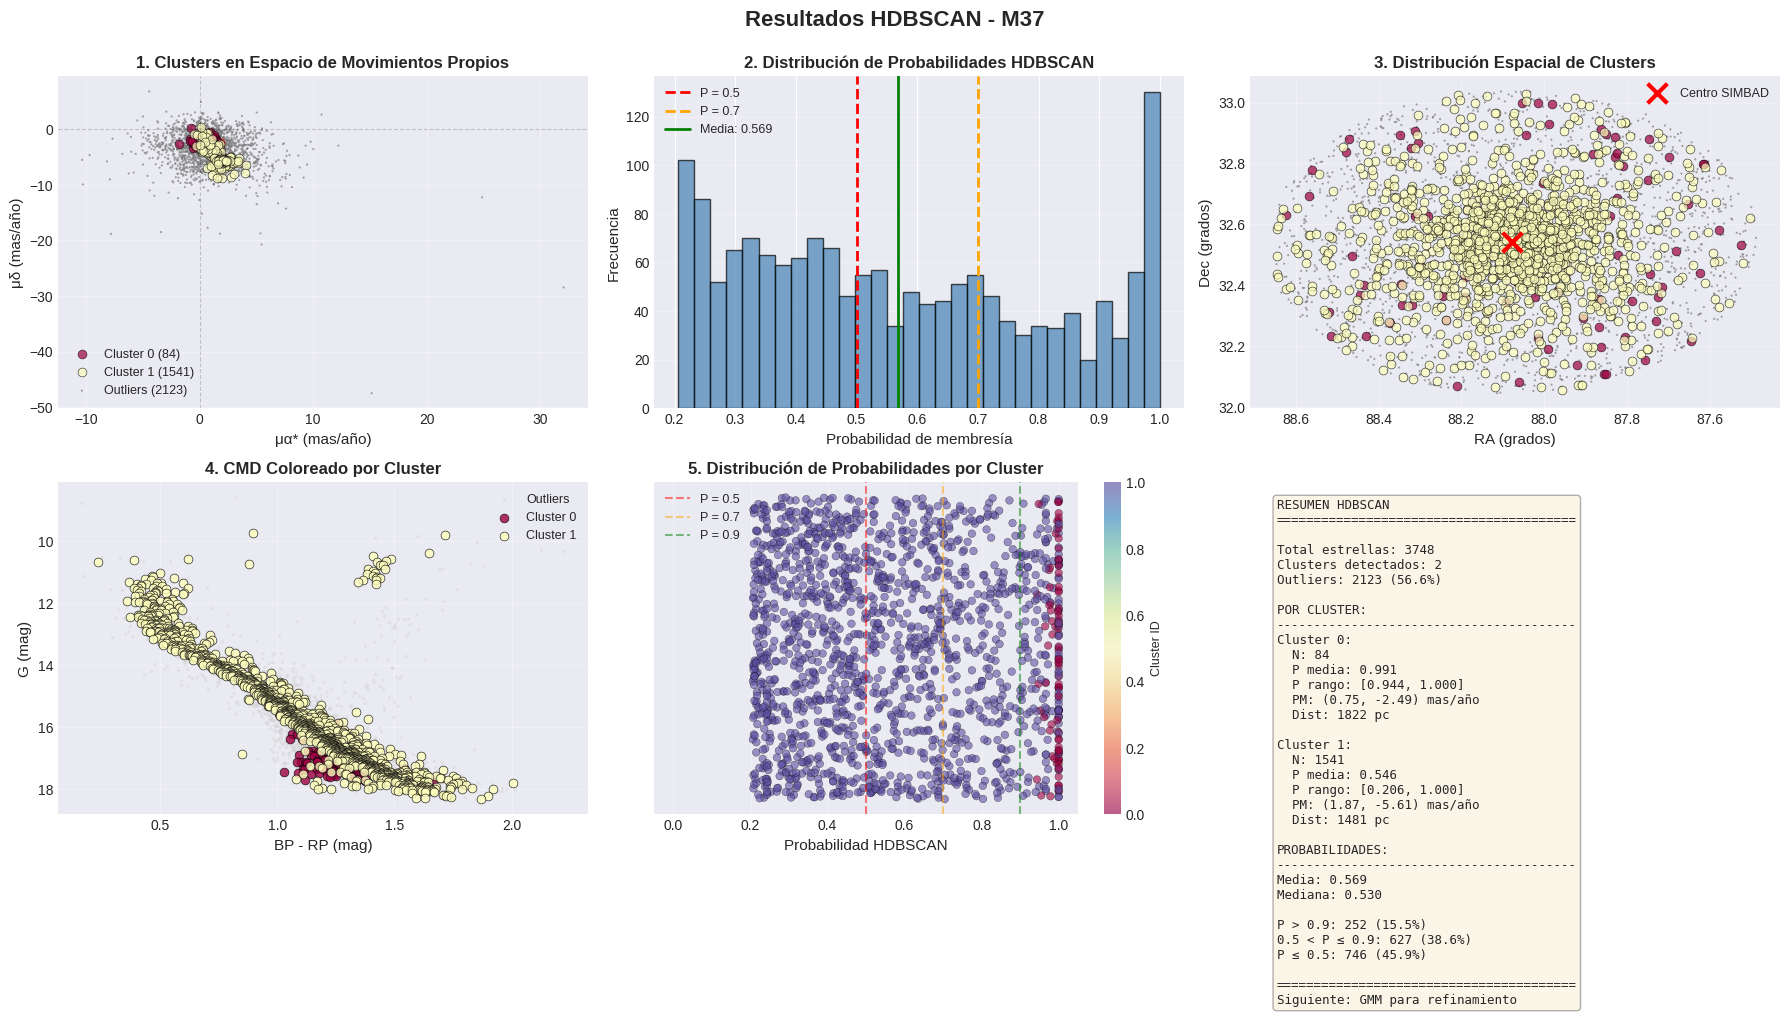


ANÁLISIS VISUAL COMPLETADO

⚠️ MÚLTIPLES CLUSTERS: 2 detectados

Interpretaciones posibles:
  • Sub-estructuras reales en el cúmulo
  • Múltiples cúmulos en la región
  • Fragmentación artificial (min_cluster_size muy pequeño)

GMM ayudará a identificar el cluster principal



In [34]:
plot_hdbscan_results(X, labels_hdbscan, probs_hdbscan, data_filtered)

In [36]:
# Combinar ambos clusters en uno solo
labels_m37 = labels_hdbscan.copy()
labels_m37[labels_hdbscan >= 0] = 0  # Todos los clusters detectados → M37

In [37]:
print(f"Estrellas en M37: {np.sum(labels_m37 == 0)}")  # Debería dar 1625
print(f"Outliers: {np.sum(labels_m37 == -1)}")    

Estrellas en M37: 1625
Outliers: 2123


In [39]:
# Preparar datos para GMM (solo el cluster M37)
X_m37 = X[labels_m37 == 0]
data_m37 = data_filtered[labels_m37 == 0]
probs_hdbscan = probs_hdbscan[labels_m37 == 0]  # Guardar para comparar

In [41]:
# =========================================================================
# PASO 3: GMM
# =========================================================================
gmm, labels_gmm, probs_gmm, membership_probs, cluster_comp = apply_gmm(
    X_m37, len(set(labels_m37)) - (1 if -1 in labels_m37 else 0), 
    labels_m37
)
# results['gmm'] = {
#     'model': gmm,
#     'labels': labels_gmm,
#     'probabilities': probs_gmm,
#     'membership_probs': membership_probs,
#     'cluster_component': cluster_comp
# }

    


FASE 2: REFINAMIENTO CON GAUSSIAN MIXTURE MODEL

Configuración GMM:
  - Clusters detectados por HDBSCAN: 1
  - Componentes GMM: 2 (1 cúmulo(s) + 1 campo)

Probando GMM con diferentes números de componentes...
  n=2: BIC=5197.8, AIC=5095.3
  n=3: BIC=4681.7, AIC=4525.3

✓ Mejor número de componentes según BIC: 3

Resultados GMM:
  ✓ Componente identificado como cúmulo: 2
  ✓ Compacidad relativa de componentes:
     Componente 0: 4.93e-03
     Componente 1: 8.31e-03
     Componente 2: 1.24e-04 ← CÚMULO



Generando visualizaciones de GMM...


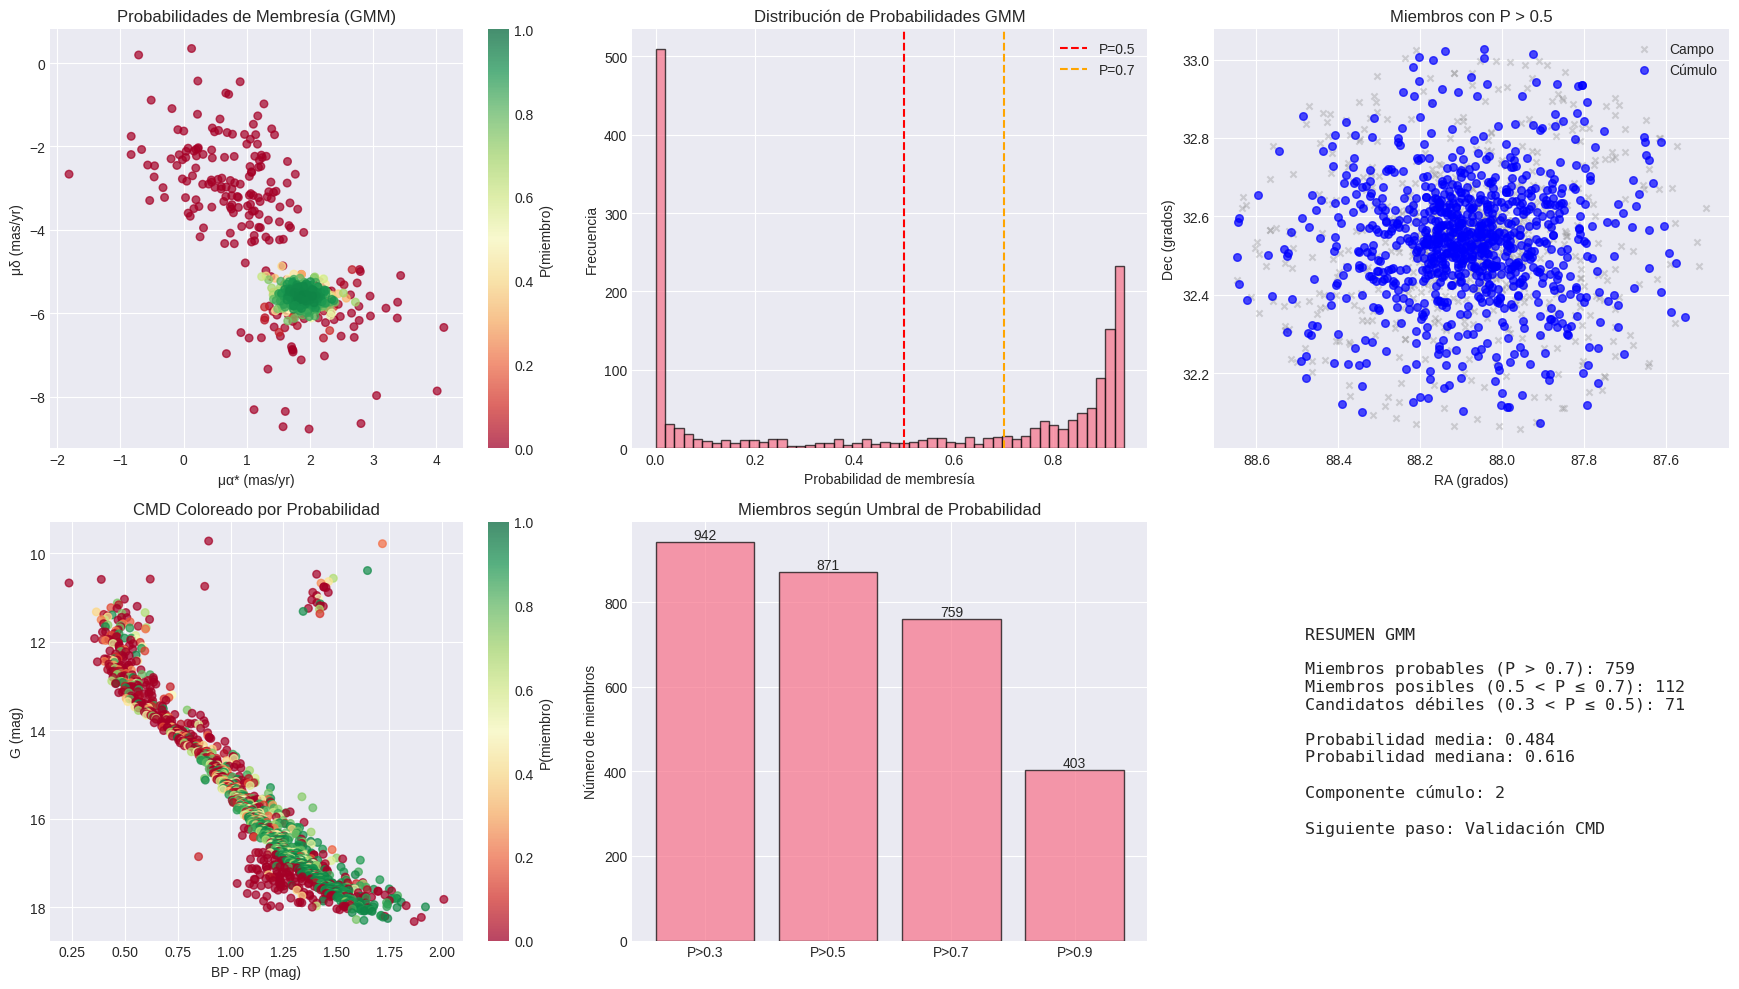

In [43]:
plot_gmm_results(X_m37, labels_gmm, membership_probs, cluster_comp, data_m37)

In [ ]:
# ============================================================================
# CONFIGURACIÓN ÓPTIMA PARA M37
# ============================================================================

# 1. Datos ya filtrados (1450 estrellas)
data_filtered = data  # Tu DataFrame actual

# 2. Preparar características (PRUEBA AMBAS OPCIONES)

# OPCIÓN A: Con parallax
X_full, medians_full, mad_full, weights_full = prepare_features(
    data_filtered,
    features=['pmra', 'pmdec', 'parallax'],
    use_errors=True
)

# OPCIÓN B: Solo PM (a veces mejor para cúmulos lejanos)
X_pm, medians_pm, mad_pm, weights_pm = prepare_features(
    data_filtered,
    features=['pmra', 'pmdec'],
    use_errors=True
)

# 3. HDBSCAN con parámetros MUY permisivos
print("\n" + "="*70)
print("PRUEBA 1: Con PM + Parallax")
print("="*70)

clusterer1, labels1, probs1, _ = apply_hdbscan(
    X_full,
    min_cluster_size=10,
    min_samples=3
)

print("\n" + "="*70)
print("PRUEBA 2: Solo PM")
print("="*70)

clusterer2, labels2, probs2, _ = apply_hdbscan(
    X_pm,
    min_cluster_size=10,
    min_samples=3
)

# 4. Comparar resultados
n_main1 = (labels1 == 0).sum() if (labels1 >= 0).sum() > 0 else 0
n_main2 = (labels2 == 0).sum() if (labels2 >= 0).sum() > 0 else 0

print("\n" + "="*70)
print("COMPARACIÓN")
print("="*70)
print(f"Con PM + Plx: {n_main1} miembros")
print(f"Solo PM:      {n_main2} miembros")

# 5. Usar la mejor opción
if n_main2 > n_main1 * 1.5:  # Solo PM es 50% mejor
    print("\n✓ Usar SOLO PM (mejor resultado)")
    X, labels, probs = X_pm, labels2, probs2
    features_used = ['pmra', 'pmdec']
else:
    print("\n✓ Usar PM + Parallax")
    X, labels, probs = X_full, labels1, probs1
    features_used = ['pmra', 'pmdec', 'parallax']

# 6. Visualizar
if (labels >= 0).sum() > 0:
    plot_hdbscan_results(X, labels, probs, data_filtered, features_used)
else:
    print("\n⚠️ Todavía sin clusters, revisar plot_raw_data()")